In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from keras import layers
from keras import optimizers
import io

Using TensorFlow backend.


In [2]:
dictionary={
    'Chembarambaakam':0,
    'Chozhavaram':1,
    'Poondi':2,
    'RedHills':3
}
revdict={
   
    0:'Chembarambaakam',
    1:'Chozhavaram',
    2:'Poondi',
    3:'RedHills'
}
dianna=[]
    
dianna.append(pd.read_csv('D:\Semester 4\Soft Computing\Chennai Water Supply Manager\\CHdianna.csv',na_values=-1))
dianna.append(pd.read_csv('D:\Semester 4\Soft Computing\Chennai Water Supply Manager\\CZdianna.csv',na_values=-1))
dianna.append(pd.read_csv('D:\Semester 4\Soft Computing\Chennai Water Supply Manager\\PNdianna.csv',na_values=-1))
dianna.append(pd.read_csv('D:\Semester 4\Soft Computing\Chennai Water Supply Manager\\RHdianna.csv',na_values=-1))
for i in range(0,4):
    print('\n',revdict[i],':\n')
    dianna[i]=dianna[i].dropna()
    dianna[i]=dianna[i].reset_index(drop=True)
    print(dianna[i].tail())


 Chembarambaakam :

            Date  nth day in year  Storage (mcft)  Inflow (cusecs)  \
5083  27/12/2017              360          1863.0              0.0   
5084  28/12/2017              361          1859.0              0.0   
5085  29/12/2017              362          1855.0              0.0   
5086  30/12/2017              363          1851.0              0.0   
5087  31/12/2017              364          1847.0              0.0   

      Rainfall (mm)  Outflow (cusecs)  
5083            0.0              49.0  
5084            0.0              49.0  
5085            0.0              49.0  
5086            0.0              49.0  
5087            0.0              49.0  

 Chozhavaram :

            Date  nth day in year  Storage (mcft)  Inflow (cusecs)  \
5093  27/12/2017              360           528.0              0.0   
5094  28/12/2017              361           525.0              0.0   
5095  29/12/2017              362           522.0              0.0   
5096  30/12/2017     

In [70]:
#THE MATH MAGIC CELL
mathprocessor=dianna[0].loc[4727:,:]

xinter=mathprocessor.loc[::5,'nth day in year']
yinter=mathprocessor.loc[::5,'nth day in year']
xmath=xinter.reset_index()
ymath=yinter.reset_index()
xmath.drop(columns=['index'],inplace=True)

ymath.drop(columns=['index'],inplace=True)
xmath=np.array(xmath.loc[:,'nth day in year'].values)
ymath=np.array(ymath.loc[:,'nth day in year'].values)
#CEF FUNCTION: To calculate newton del coeffecients
def coef(x, y):
    n = len(y)
    a = []
    for i in range(n):
        a.append(y[i])

    for j in range(1, n):

        for i in range(n-1, j-1, -1):
            a[i] = float(a[i]-a[i-1])/float(x[i]-x[i-j])

    return np.array(a) # return an array of coefficient

#eval function: to use newton backward/foward formula and return outflow
def Eval(a, x, r):
    x.astype(float)
    n = len( a ) - 1
    temp = a[n] + (r - x[n])
    for i in range( n - 1, -1, -1 ):
        temp = temp * ( r - x[i] ) + a[i]
    return temp # return the y_value interpolation

newton_interpolator=list()
for i in range(0,len(dianna[0])):
    newton_interpolator.append(Eval(coef(xmath,ymath),xmath,dianna[0].loc[i,"nth day in year"]))

In [5]:
#MIN-MAX NORMALISATION
def normaliser(data):
                              siro=data.drop(columns=['Date','nth day in year'])
                              '''for i in ['Storage (mcft)', 'Inflow (cusecs)','Rainfall (mm)','Outflow (cusecs)']:
                                siro[i]-=min(galactus[i])
                                siro[i]/=(max(galactus[i])-min(galactus[i]))'''
                              return siro
  



    
def op_re_normaliser(data):
              data['predicted']*=(max(galactus['Outflow (cusecs)'])-min(galactus['Outflow (cusecs)']))
              data['predicted']+=min(galactus['Outflow (cusecs)'])
              return data


#5-DAY SEQUENCE FOR LSTM NET
def sequence_prepare(raw,lookback=5):
                                          sequence=np.zeros(((len(raw)-lookback),lookback,raw.shape[-1]))
                                          target=np.zeros(len(raw)-lookback)

                                          for i in range(lookback, len(raw)):
                                              for j in range(0,lookback):
                                                  sequence[i-lookback][j]=raw.loc[i+j-lookback,:]
                                              target[i-lookback]=raw['Outflow (cusecs)'][i]

                                          return sequence,target


#TRAIN-VALIDATION SPLIT
def train_test_split(sequence,target,boundary=4382):
    if(boundary<1):
        x_train=sequence[:int(len(sequence)*boundary)]
        x_test=sequence[int(len(sequence)*boundary):]
        y_train=target[:int(len(target)*boundary)]
        y_test=target[int(len(target)*boundary):]
    else:
        x_train=sequence[:boundary]
        x_test=sequence[boundary:]
        y_train=target[:boundary]
        y_test=target[boundary:]
    
    return x_train, x_test, y_train, y_test
siro=[]
sequence=[]
target=[]
x_train=[]
y_train=[]
x_test=[]
y_test=[]
for i in range(0,4):

    siro.append(normaliser(dianna[i]))
    print(siro[i].describe())

    sequ,targ=sequence_prepare(siro[i])
    sequence.append(sequ)
    target.append(targ)
    
    
minn=10000
for i in range(0,4):
    minn=min(minn,len(sequence[i]))
for i in range(0,4):
    sequence[i]=sequence[i][:minn]
    target[i]=target[i][:minn]
    
    
    
for i in range(0,4):
    x_tr, x_te, y_tr, y_te=train_test_split(sequence[i],target[i])
    x_train.append(x_tr)
    x_test.append(x_te)
    y_train.append(y_tr)
    y_test.append(y_te)

    print(x_train[i].shape,
        x_test[i].shape,
        y_train[i].shape,
        y_test[i].shape)

       Storage (mcft)  Inflow (cusecs)  Rainfall (mm)  Outflow (cusecs)
count     5088.000000      5088.000000    5088.000000       5088.000000
mean      1397.047396       135.541903       4.175914        124.462264
std        957.465642       657.534232      16.963576        639.720457
min          0.000000         0.000000       0.000000          0.000000
25%        581.500000         0.000000       0.000000         48.000000
50%       1311.500000         0.000000       0.000000         80.000000
75%       2204.000000       102.250000       0.000000        124.000000
max       3396.000000     26000.000000     475.000000      29000.000000
       Storage (mcft)  Inflow (cusecs)  Rainfall (mm)  Outflow (cusecs)
count     5098.000000      5098.000000    5098.000000       5098.000000
mean       255.192069        26.837032       3.792311         19.778737
std        281.009015       123.738900      14.446572         72.559270
min          0.000000         0.000000       0.000000          0

In [4]:
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import layers

#model.add(layers.Reshape((1,5,4)))
#model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Flatten())`

xin=[]
lstm=[]
cnnraw=[]
cnn=[]
x=[]
xout=[]
xd=[]
#model.add(layers.Reshape((5,16)))
lookback=5
for i in range(0,4):
    xin.append(layers.Input(shape=(lookback,4),name=('Input'+str(i))))
    lstm.append(layers.LSTM(32,
                            dropout=0.1,
                            recurrent_dropout=0.5,
                            activation='relu',
                            return_sequences=True,
                            #input_shape=(5,4)
                         name=('LSTM'+str(i)))(xin[i]))

    '''model.add(layers.LSTM(100, 
                            dropout=0.1,
                            recurrent_dropout=0.5))
    model.add(layers.Reshape((None,5,32)))
    model.add(layers.Conv2D(32, (2,2), activation='relu'))
    model.add(layers.Flatten())'''
    
    cnnraw.append(layers.Conv1D(4,1,activation='relu')(xin[i]))
    
    #cnn.append(layers.Flatten()(cnnraw[i]))
    




    x.append(layers.Concatenate(name=('C-Cat'+str(i)))([lstm[i], cnnraw[i]]))
    
    cnn.append(layers.Flatten()(x[i]))
    xout.append(layers.Dense(1,activation='relu',
                            name=('out'+str(i)))(cnn[i]))

                
model=models.Model(inputs=xin,outputs=xout)
model.compile(loss='mae', optimizer=optimizers.RMSprop())
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input0 (InputLayer)             [(None, 5, 4)]       0                                            
__________________________________________________________________________________________________
Input1 (InputLayer)             [(None, 5, 4)]       0                                            
__________________________________________________________________________________________________
Input2 (InputLayer)             [(None, 5, 4)]       0                                            
__________________________________________________________________________________________________
Input3 (InputLayer)             [(None, 5, 4)]       0                     

In [24]:
model=models.load_model('kanmaniv28_2.h5')

In [28]:
history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=256, 
                    validation_data=(x_test, y_test))

Train on 4382 samples, validate on 700 samples
Epoch 1/200
4382/4382 [==============================] - 5s 1ms/sample - loss: 134.3922 - out0_loss: 35.8897 - out1_loss: 4.6154 - out2_loss: 74.8113 - out3_loss: 15.1815 - val_loss: 31.4432 - val_out0_loss: 5.5887 - val_out1_loss: 0.8832 - val_out2_loss: 20.0747 - val_out3_loss: 4.5931
Epoch 2/200
4382/4382 [==============================] - 1s 156us/sample - loss: 135.9575 - out0_loss: 37.8026 - out1_loss: 4.6123 - out2_loss: 110.8852 - out3_loss: 16.6806 - val_loss: 27.4095 - val_out0_loss: 5.8092 - val_out1_loss: 0.8919 - val_out2_loss: 16.5179 - val_out3_loss: 4.0273
Epoch 3/200
4382/4382 [==============================] - 1s 158us/sample - loss: 135.1986 - out0_loss: 35.0895 - out1_loss: 4.6011 - out2_loss: 75.5752 - out3_loss: 14.1416 - val_loss: 29.3289 - val_out0_loss: 5.6881 - val_out1_loss: 0.7142 - val_out2_loss: 18.4263 - val_out3_loss: 4.7335
Epoch 4/200
4382/4382 [==============================] - 1s 156us/sample - loss: 134

4382/4382 [==============================] - 1s 163us/sample - loss: 134.4248 - out0_loss: 35.4174 - out1_loss: 5.0470 - out2_loss: 86.1386 - out3_loss: 14.8896 - val_loss: 29.2291 - val_out0_loss: 5.0339 - val_out1_loss: 0.8737 - val_out2_loss: 18.6236 - val_out3_loss: 4.4452
Epoch 30/200
4382/4382 [==============================] - 1s 164us/sample - loss: 136.7108 - out0_loss: 37.0311 - out1_loss: 5.7376 - out2_loss: 113.3874 - out3_loss: 20.7432 - val_loss: 29.9082 - val_out0_loss: 5.3096 - val_out1_loss: 0.7616 - val_out2_loss: 19.4353 - val_out3_loss: 4.3253
Epoch 31/200
4382/4382 [==============================] - 2s 349us/sample - loss: 132.8594 - out0_loss: 35.6244 - out1_loss: 5.5702 - out2_loss: 75.3346 - out3_loss: 14.1327 - val_loss: 30.6747 - val_out0_loss: 5.6613 - val_out1_loss: 0.8381 - val_out2_loss: 19.9340 - val_out3_loss: 4.0449
Epoch 32/200
4382/4382 [==============================] - 1s 301us/sample - loss: 139.1765 - out0_loss: 35.1308 - out1_loss: 4.7847 - out2_

4382/4382 [==============================] - 1s 322us/sample - loss: 135.0838 - out0_loss: 34.9594 - out1_loss: 5.4183 - out2_loss: 76.2180 - out3_loss: 13.9456 - val_loss: 29.6219 - val_out0_loss: 5.7088 - val_out1_loss: 0.7165 - val_out2_loss: 18.3005 - val_out3_loss: 4.6726
Epoch 86/200
4382/4382 [==============================] - 1s 197us/sample - loss: 133.3387 - out0_loss: 34.8184 - out1_loss: 4.5721 - out2_loss: 76.0211 - out3_loss: 14.0211 - val_loss: 28.6256 - val_out0_loss: 5.9792 - val_out1_loss: 0.7469 - val_out2_loss: 17.0554 - val_out3_loss: 4.6715
Epoch 87/200
4382/4382 [==============================] - 1s 203us/sample - loss: 133.1019 - out0_loss: 34.7609 - out1_loss: 4.6378 - out2_loss: 73.6014 - out3_loss: 13.9788 - val_loss: 28.6384 - val_out0_loss: 6.1307 - val_out1_loss: 0.8530 - val_out2_loss: 16.3366 - val_out3_loss: 4.9661
Epoch 88/200
4382/4382 [==============================] - 1s 245us/sample - loss: 134.8482 - out0_loss: 35.0364 - out1_loss: 4.5814 - out2_l

Epoch 141/200
4382/4382 [==============================] - 1s 222us/sample - loss: 133.4646 - out0_loss: 34.8688 - out1_loss: 5.1852 - out2_loss: 74.4094 - out3_loss: 14.0292 - val_loss: 30.0979 - val_out0_loss: 5.7960 - val_out1_loss: 0.7418 - val_out2_loss: 18.5630 - val_out3_loss: 4.7911
Epoch 142/200
4382/4382 [==============================] - 1s 180us/sample - loss: 133.0384 - out0_loss: 39.0730 - out1_loss: 4.8768 - out2_loss: 78.6315 - out3_loss: 15.6254 - val_loss: 28.7683 - val_out0_loss: 5.9441 - val_out1_loss: 0.8421 - val_out2_loss: 17.0271 - val_out3_loss: 4.9414
Epoch 143/200
4382/4382 [==============================] - 1s 204us/sample - loss: 130.9202 - out0_loss: 34.8384 - out1_loss: 4.6477 - out2_loss: 72.6023 - out3_loss: 14.0609 - val_loss: 30.8878 - val_out0_loss: 5.5396 - val_out1_loss: 0.9391 - val_out2_loss: 20.1951 - val_out3_loss: 4.3936
Epoch 144/200
4382/4382 [==============================] - 1s 209us/sample - loss: 133.5425 - out0_loss: 34.8284 - out1_loss

Epoch 197/200
4382/4382 [==============================] - 1s 187us/sample - loss: 135.7658 - out0_loss: 34.6600 - out1_loss: 4.7480 - out2_loss: 78.2617 - out3_loss: 13.8972 - val_loss: 29.9683 - val_out0_loss: 5.7958 - val_out1_loss: 0.7114 - val_out2_loss: 19.5732 - val_out3_loss: 4.4283
Epoch 198/200
4382/4382 [==============================] - 1s 176us/sample - loss: 133.5423 - out0_loss: 36.7940 - out1_loss: 4.5242 - out2_loss: 81.4850 - out3_loss: 14.2146 - val_loss: 34.1546 - val_out0_loss: 7.3545 - val_out1_loss: 0.8060 - val_out2_loss: 20.7560 - val_out3_loss: 4.8526
Epoch 199/200
4382/4382 [==============================] - 1s 181us/sample - loss: 136.8449 - out0_loss: 34.6779 - out1_loss: 4.5523 - out2_loss: 77.6393 - out3_loss: 13.7894 - val_loss: 27.9933 - val_out0_loss: 5.6495 - val_out1_loss: 0.7302 - val_out2_loss: 17.4400 - val_out3_loss: 4.2219
Epoch 200/200
4382/4382 [==============================] - 1s 177us/sample - loss: 135.4055 - out0_loss: 34.7325 - out1_loss

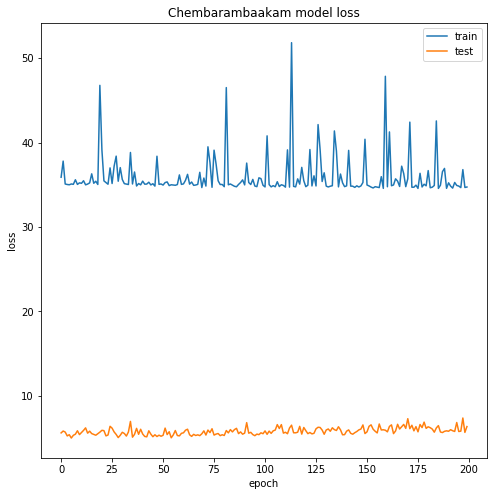

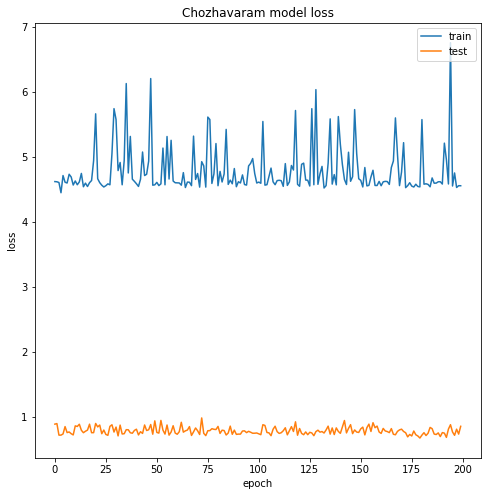

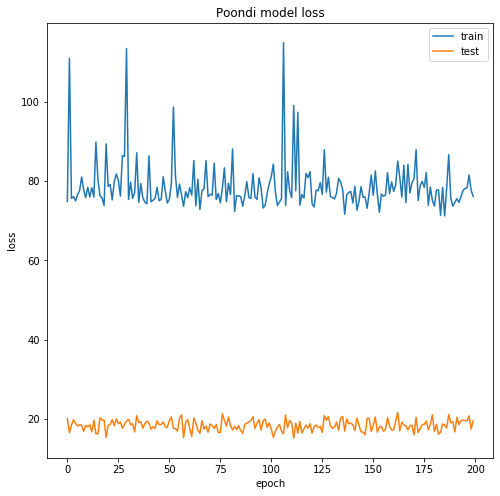

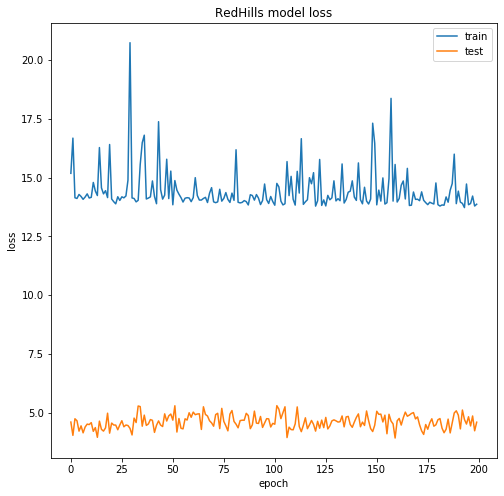

In [29]:
for ij in range(0,4):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,8))
    plt.plot(history.history['out'+str(ij)+'_loss'])
    plt.plot(history.history['val_out'+str(ij)+'_loss'])
    plt.title(revdict[ij]+' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()


In [30]:
a=[]
lookback=5
for i in range(0,4):
    a.append([])
    for _ in range(0,lookback):
        a[i].append(0)
        
        
print('Model Prediction :\nprocessing: |<',end='')
    
for i in range(0,len(sequence[0])):
    req=[sequence[0][i:i+1],sequence[1][i:i+1],sequence[2][i:i+1],sequence[3][i:i+1]]
    for ij in range(0,4):
        a[ij].append(model.predict(req)[ij][0][0])
    if(i%25==0):
            print('-',end='')

print('>|',end='')



Model Prediction :
processing: |<------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------>|

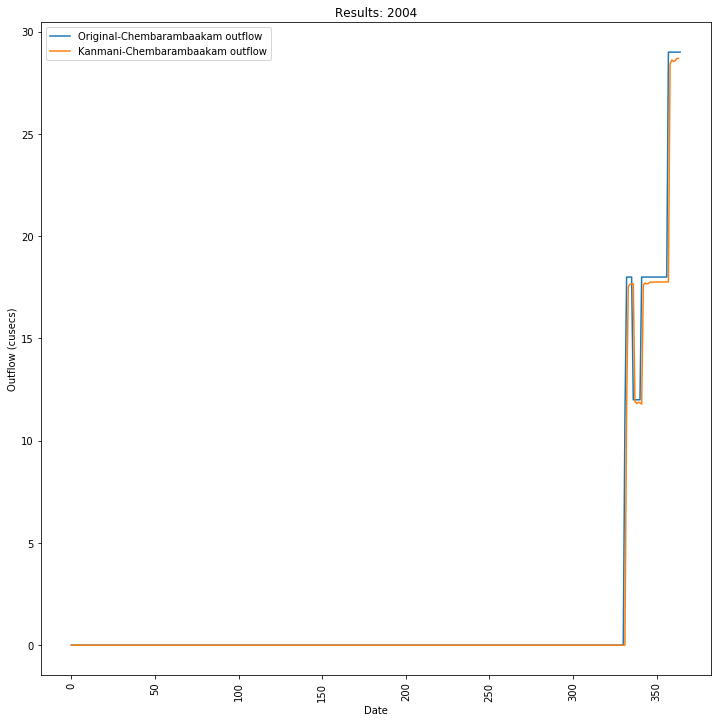

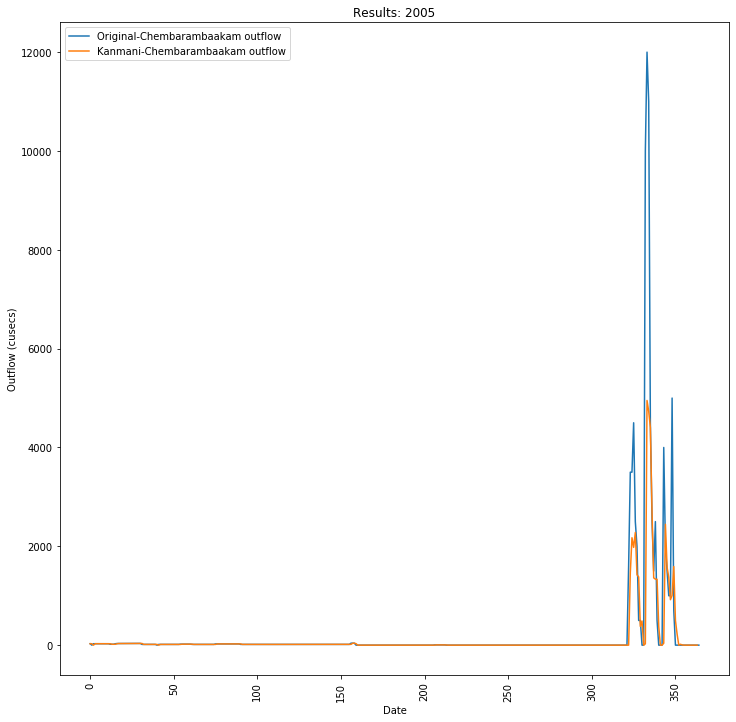

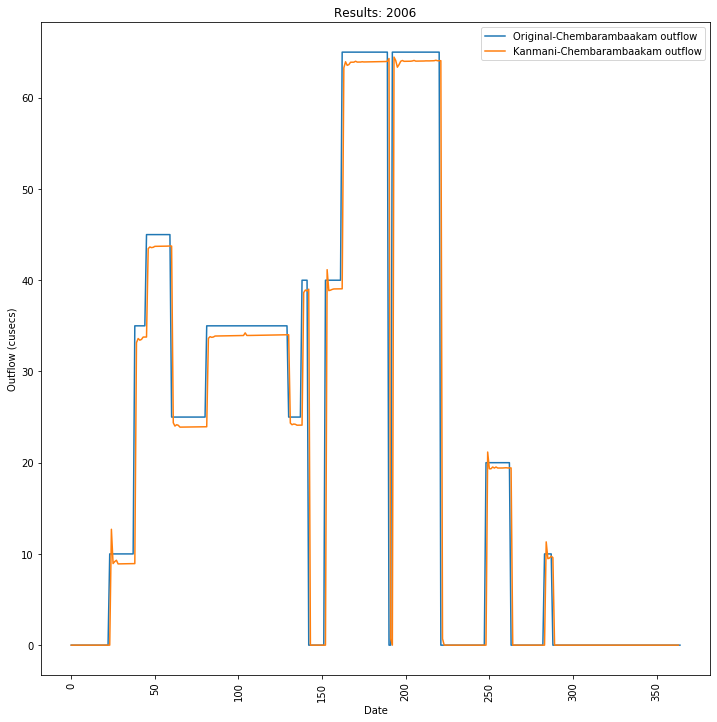

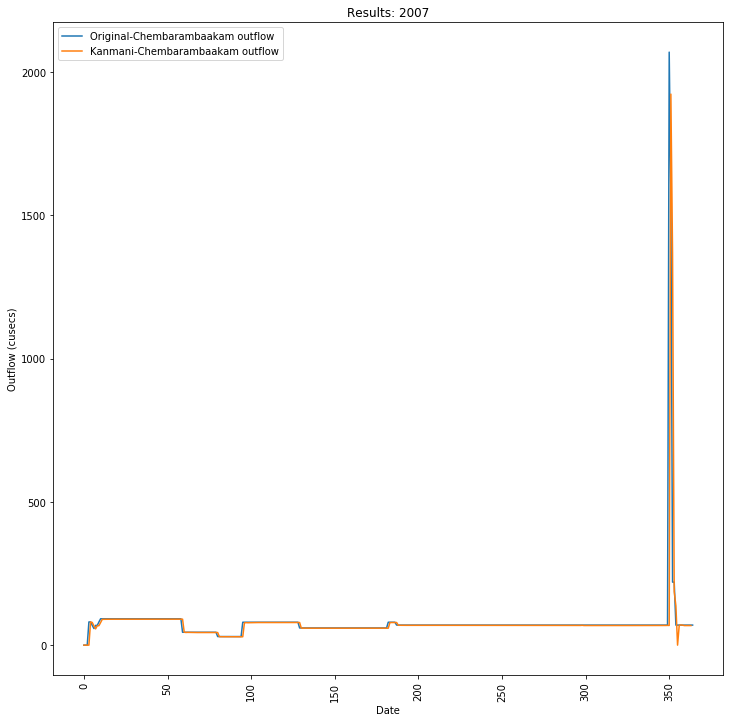

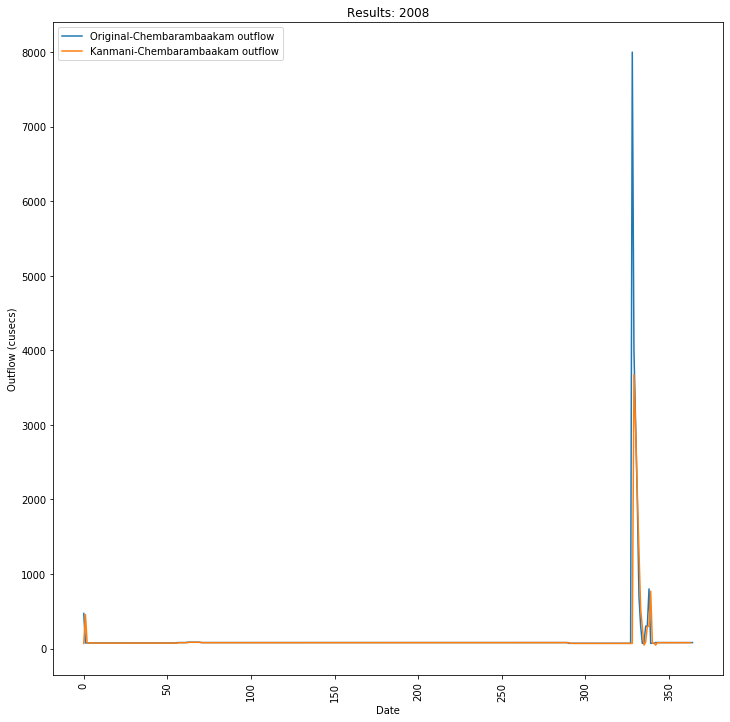

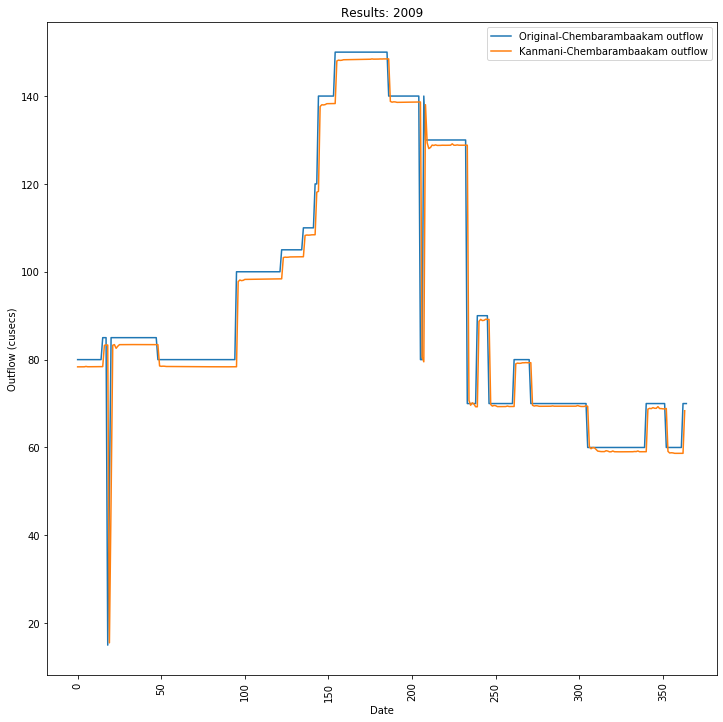

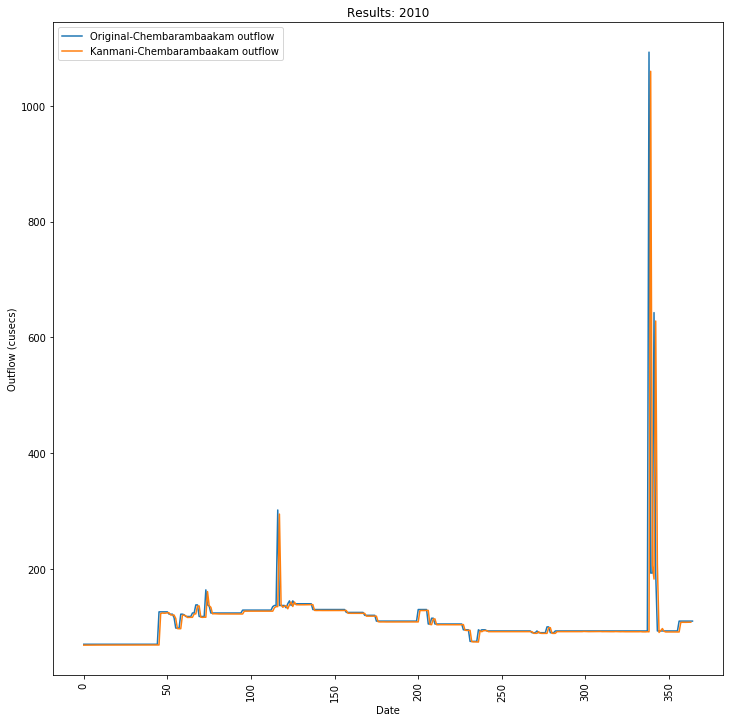

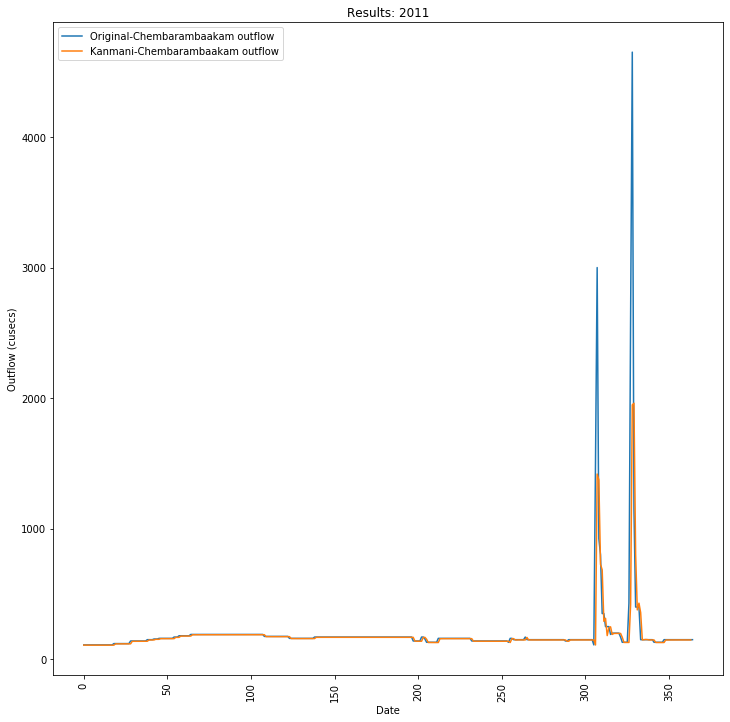

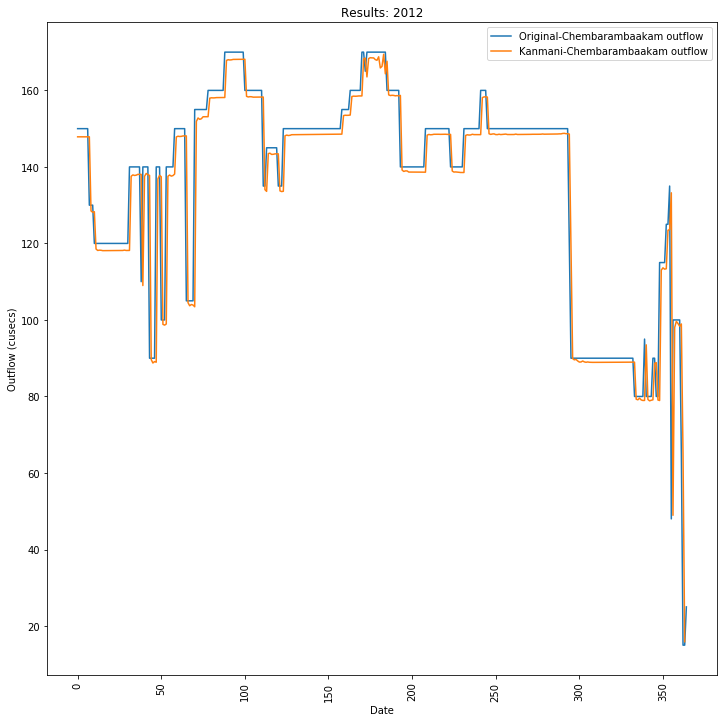

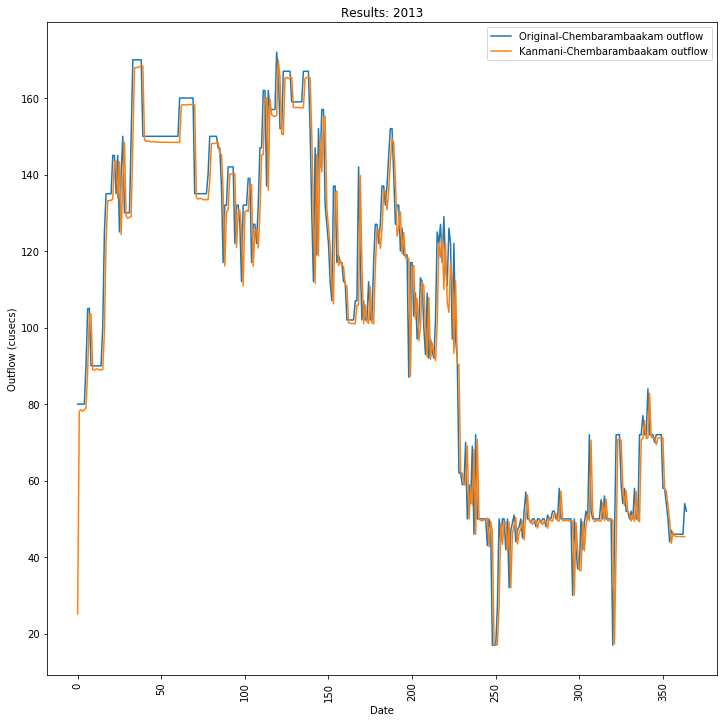

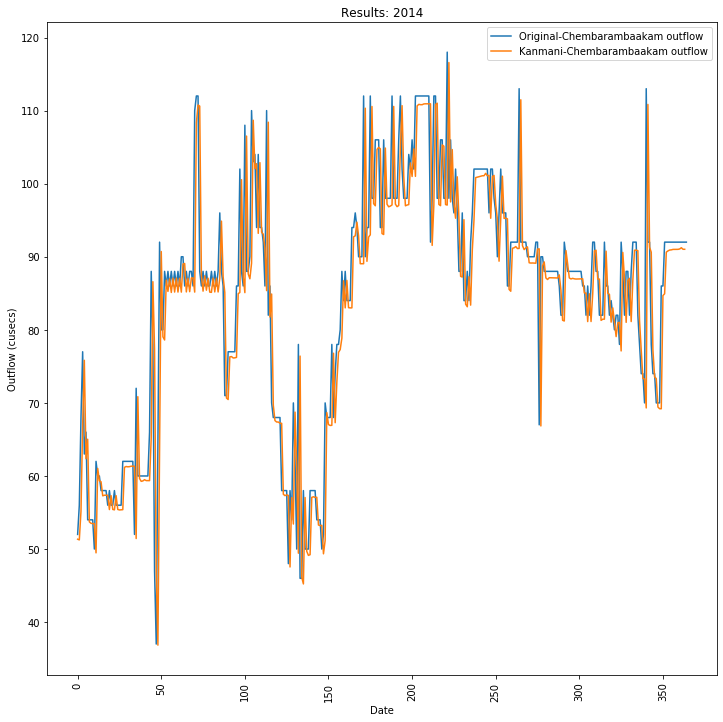

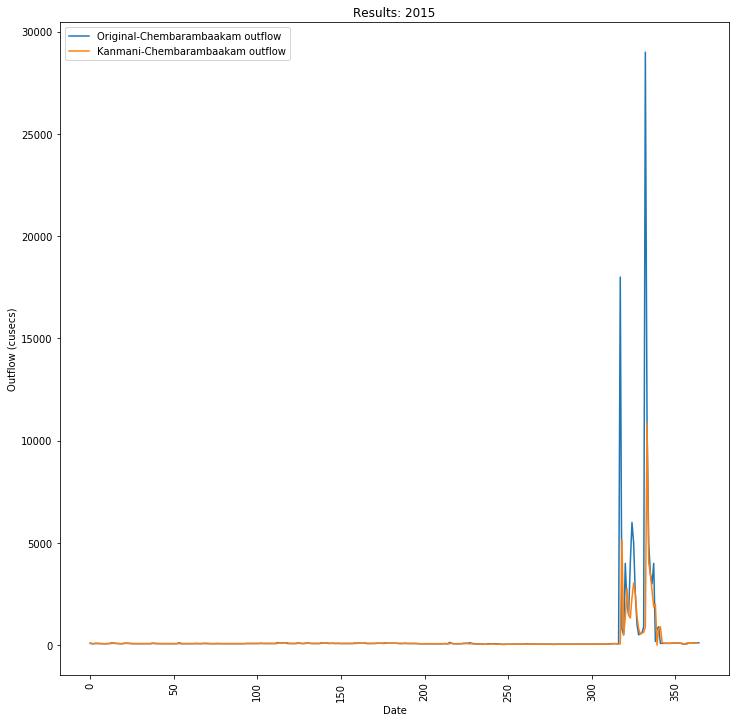

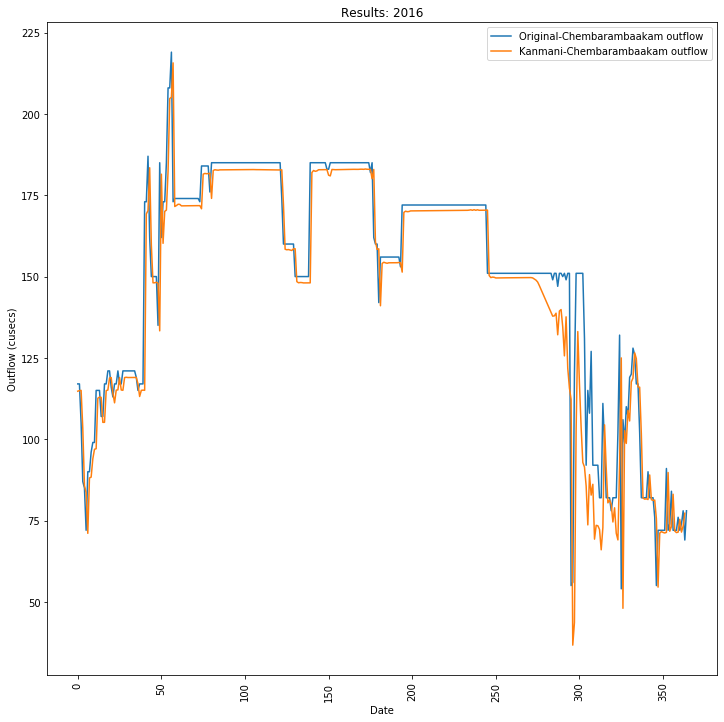

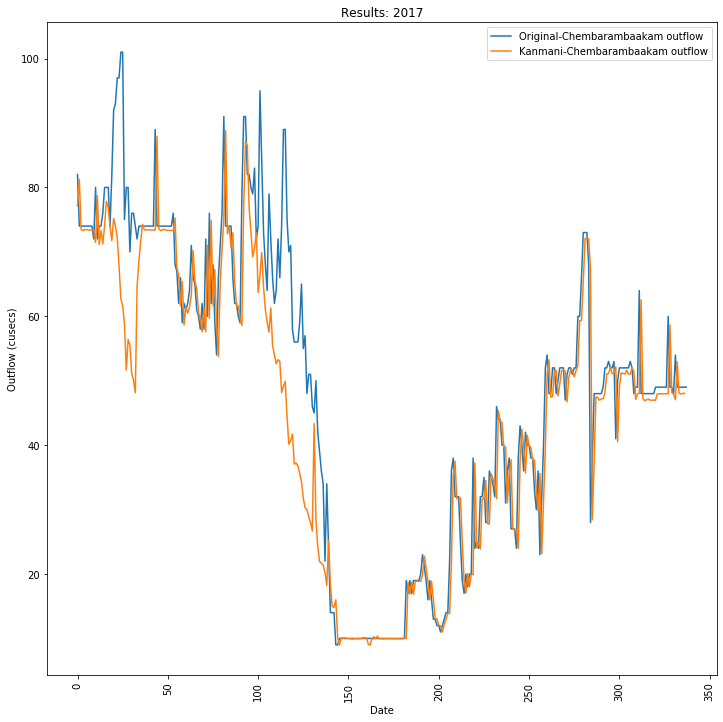

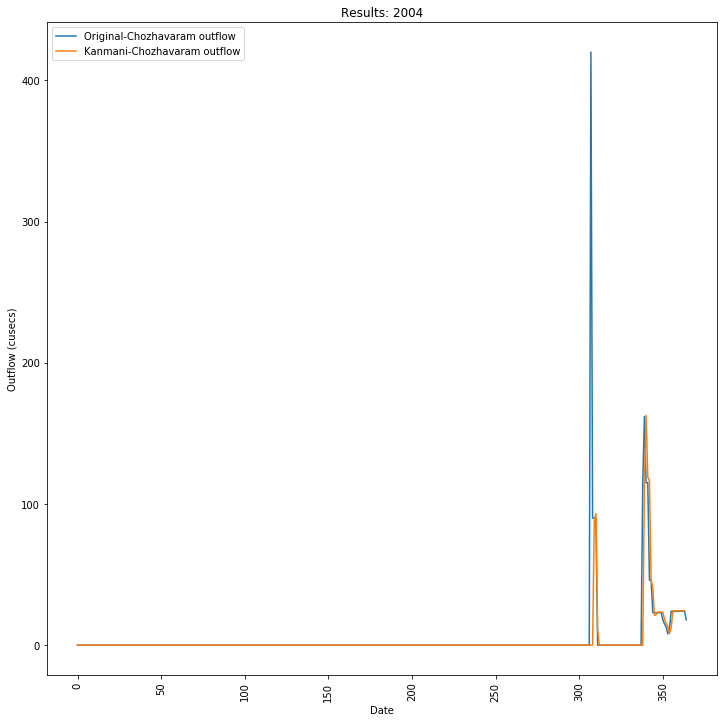

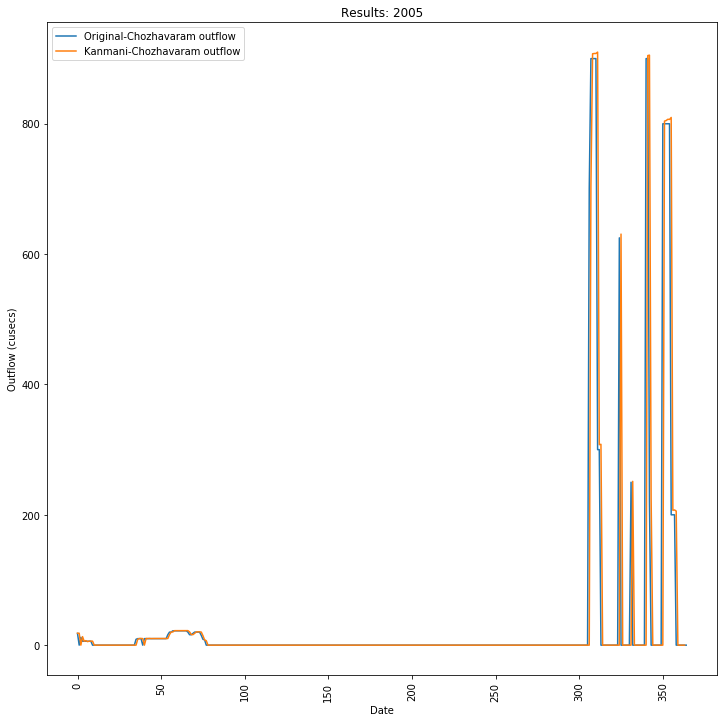

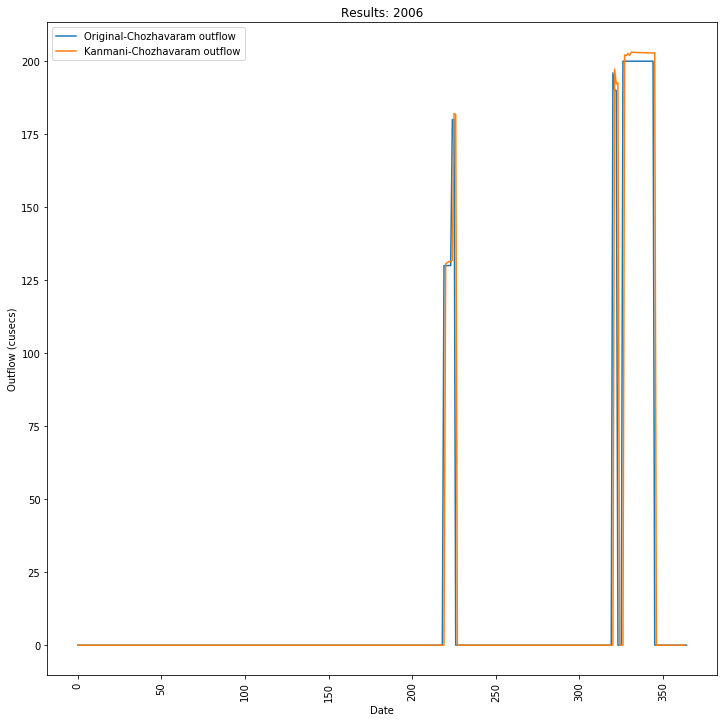

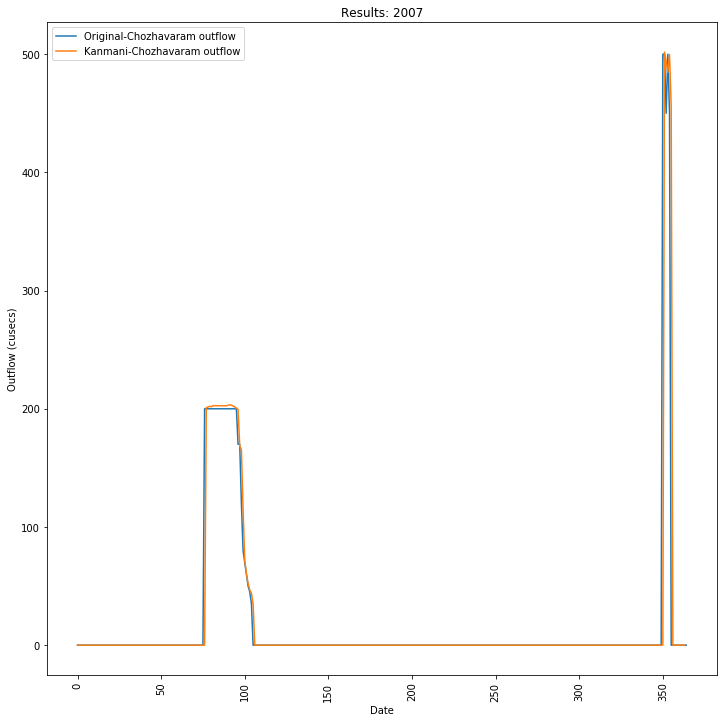

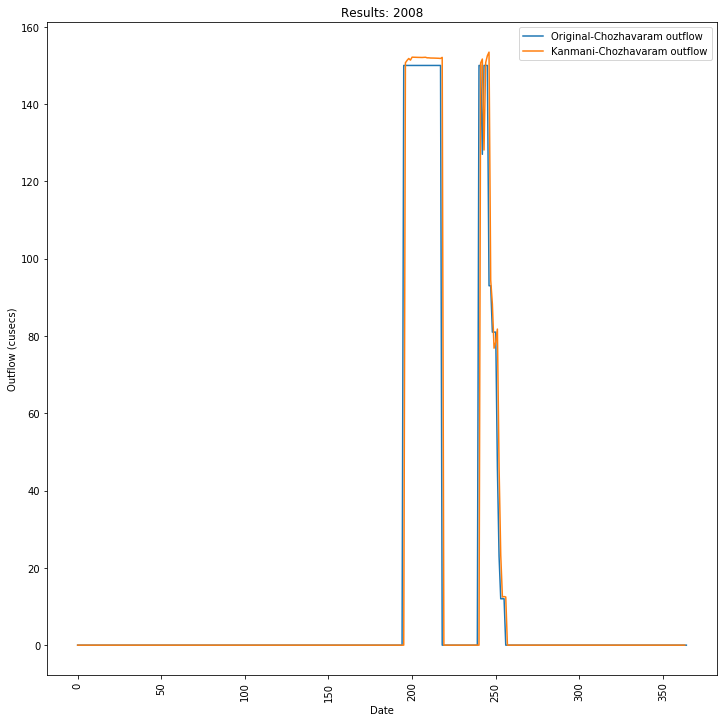

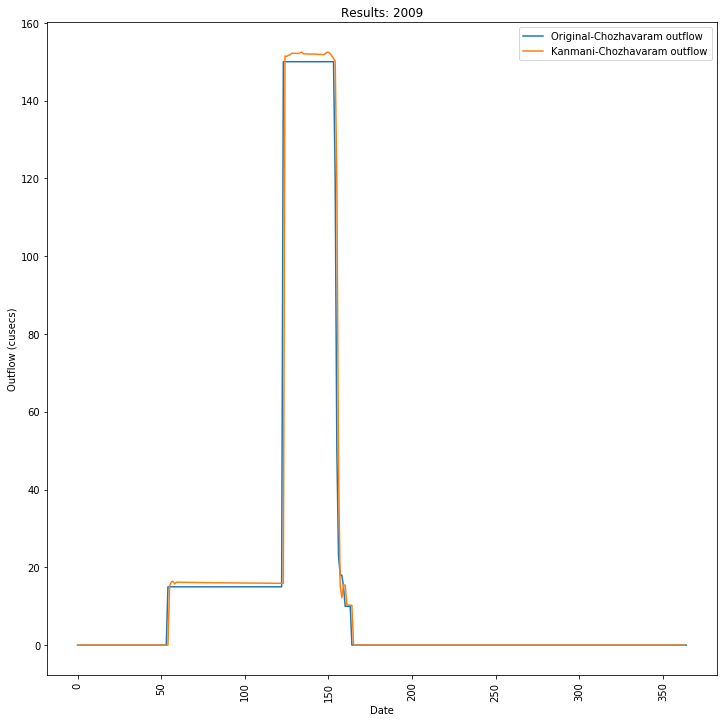

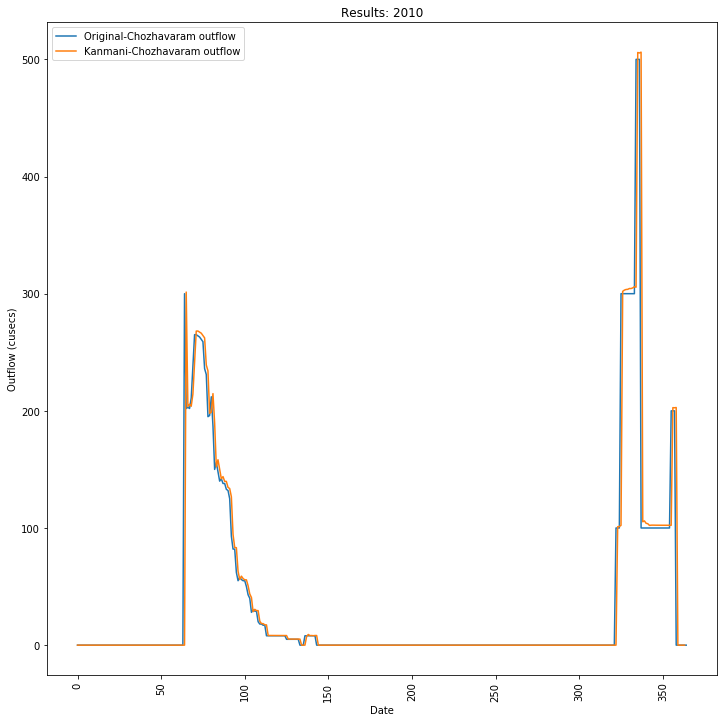

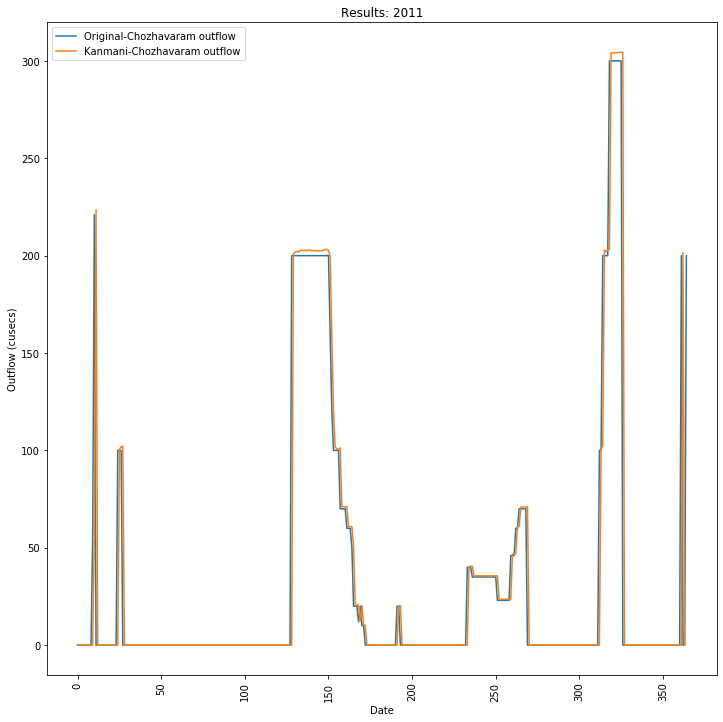

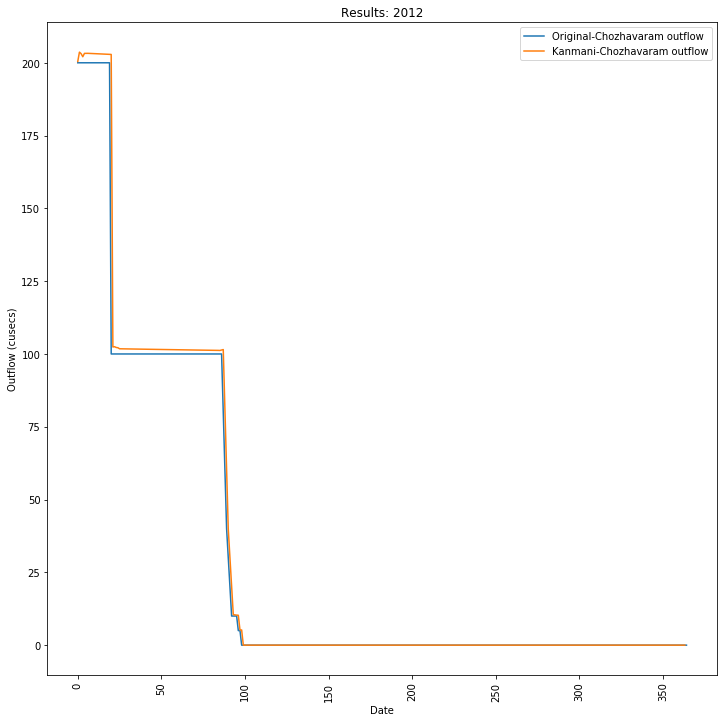

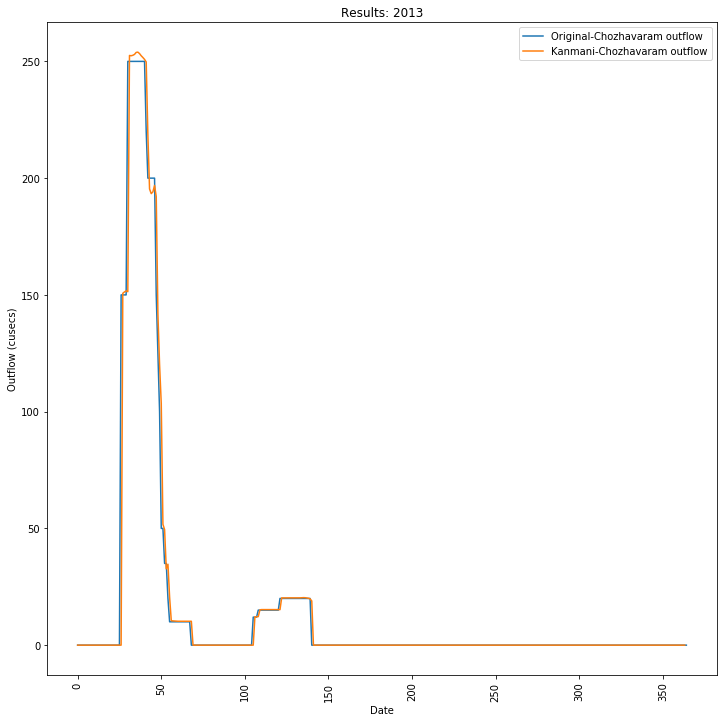

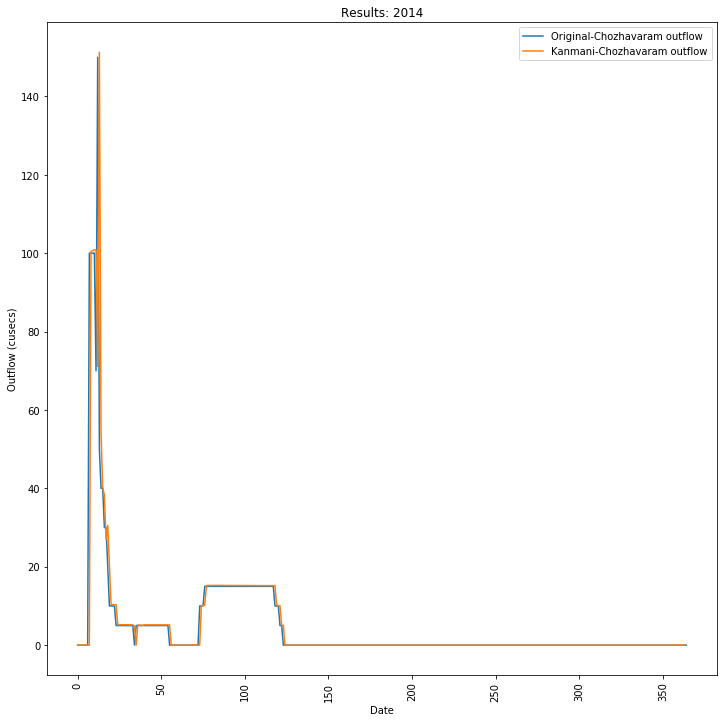

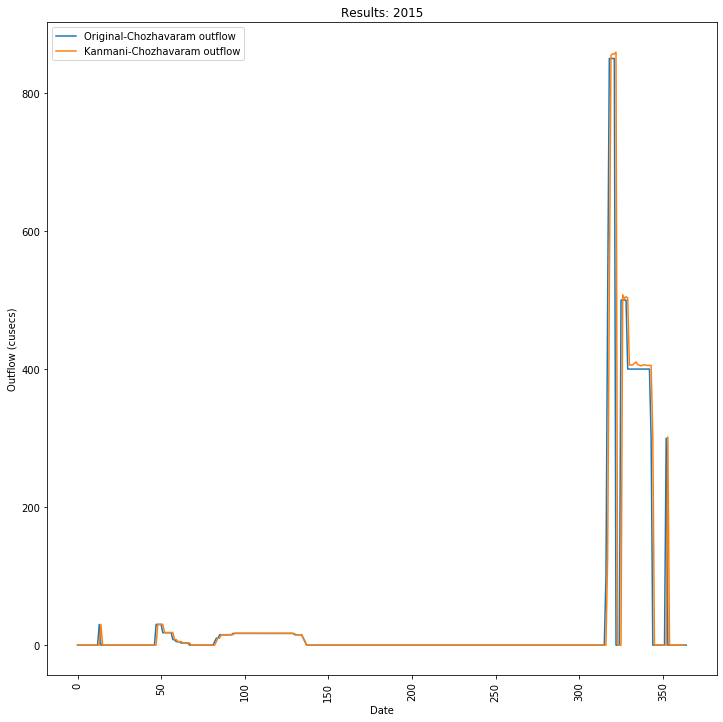

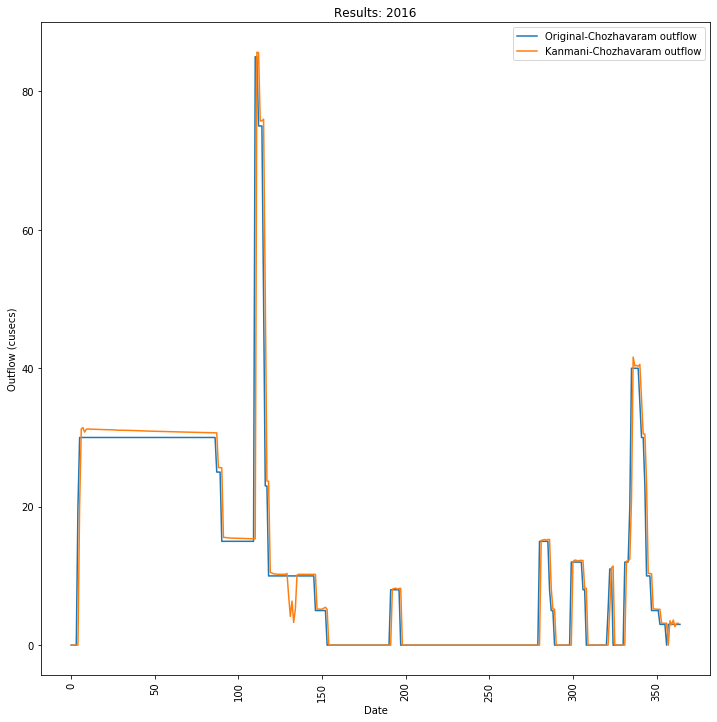

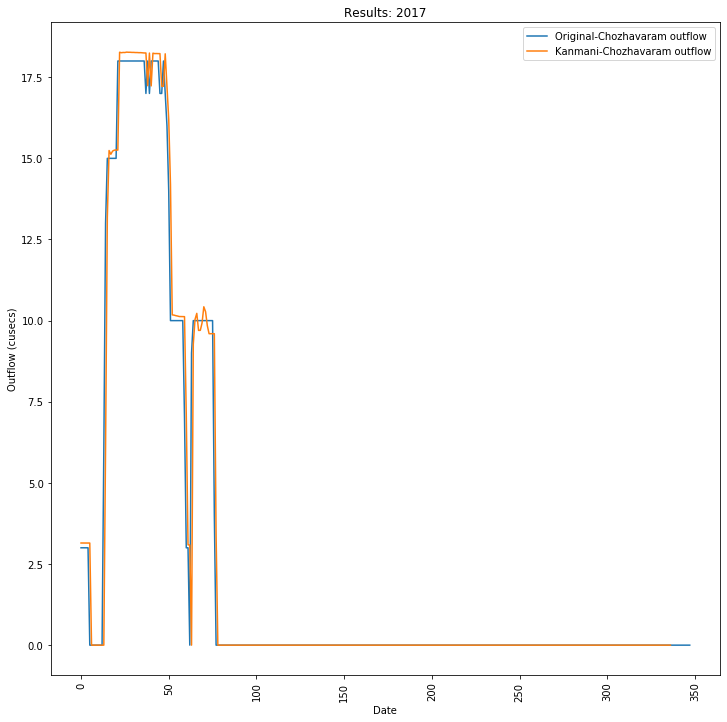

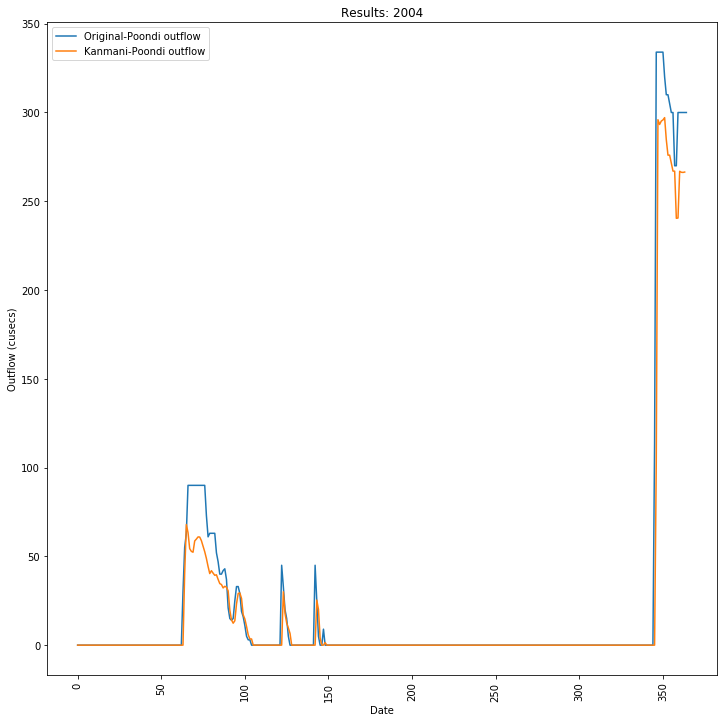

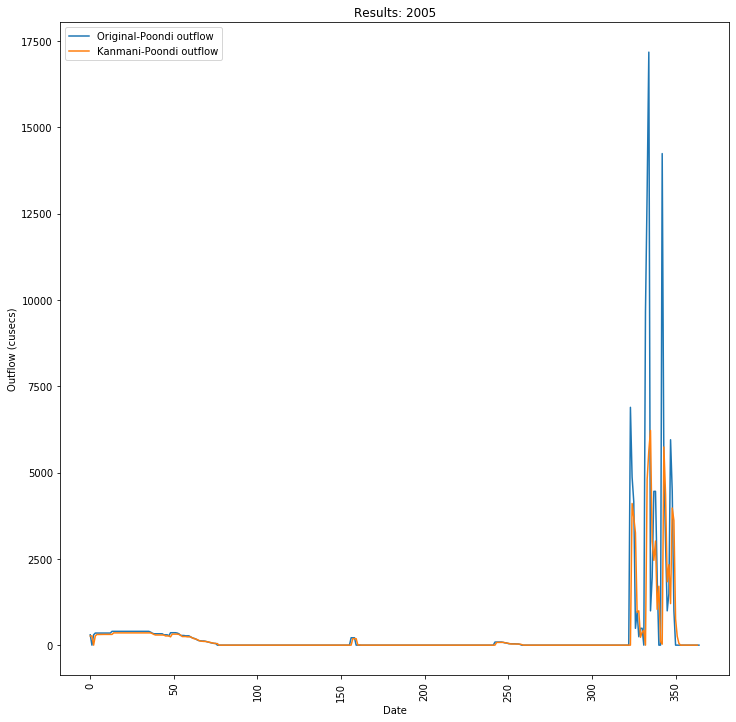

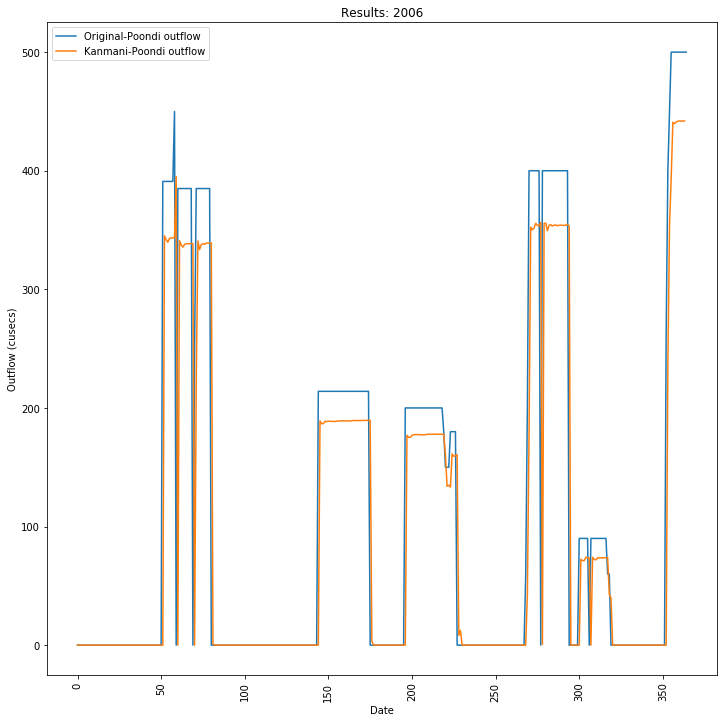

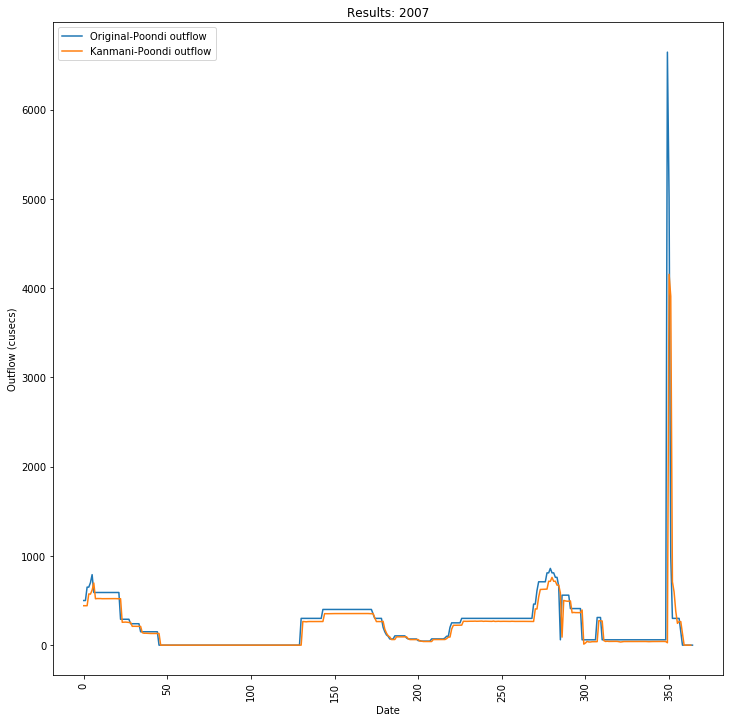

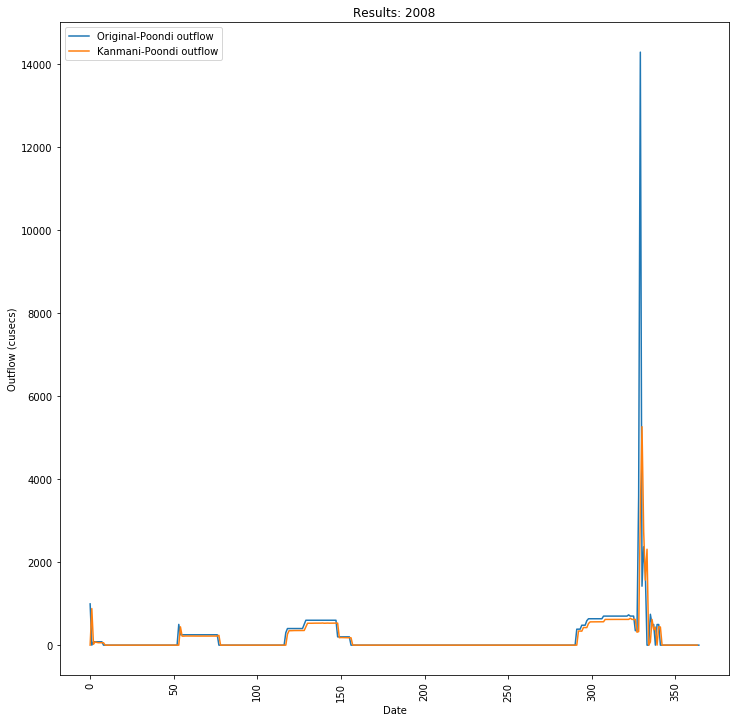

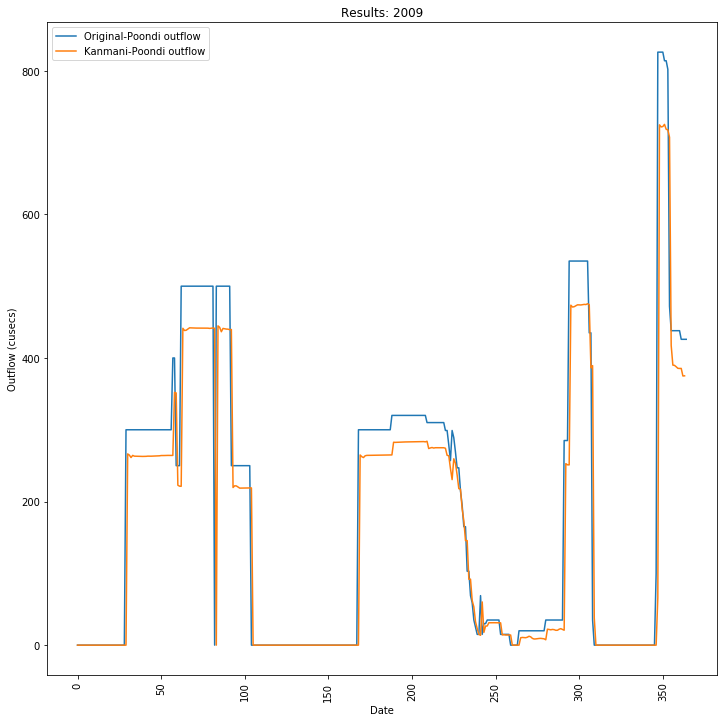

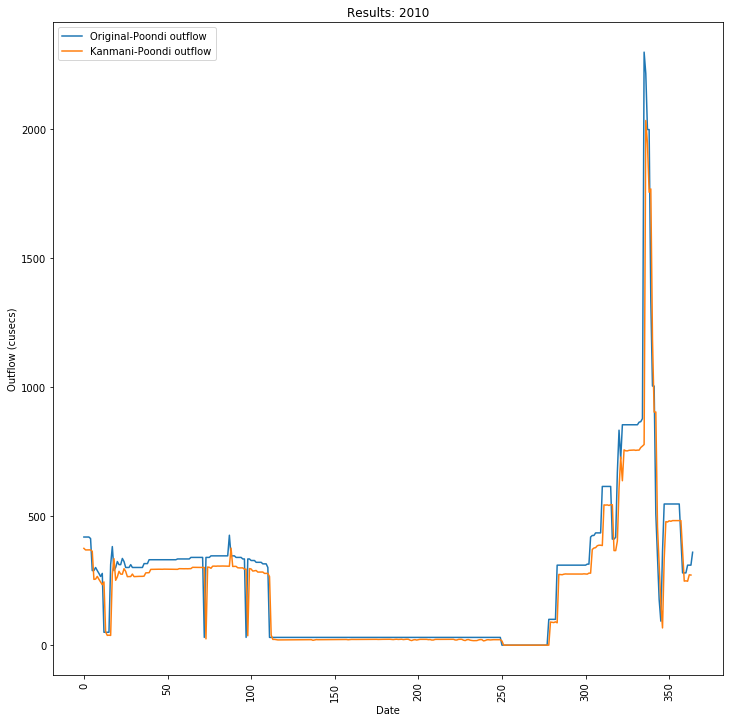

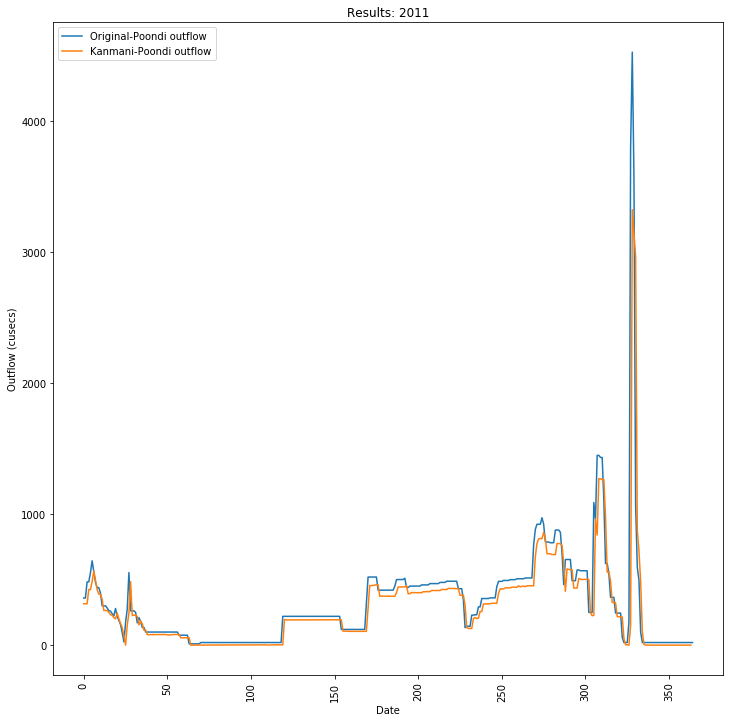

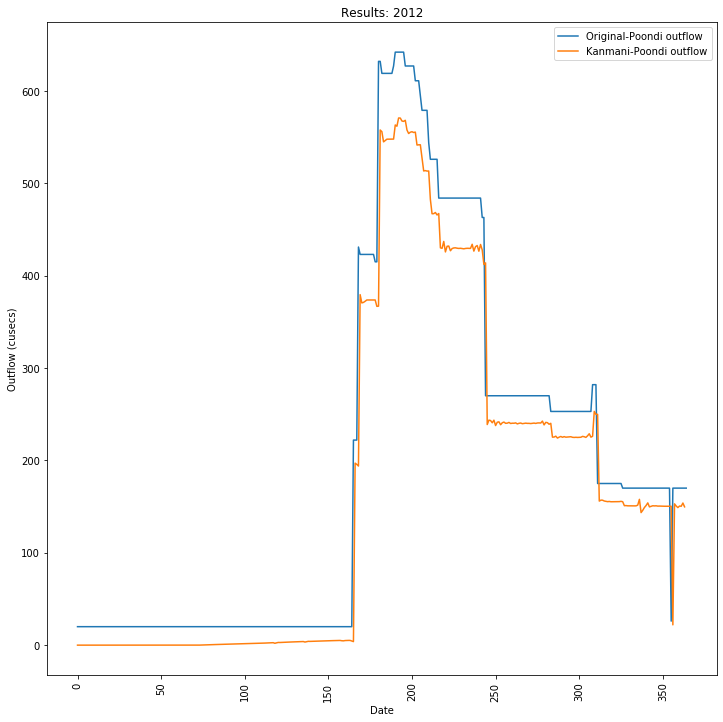

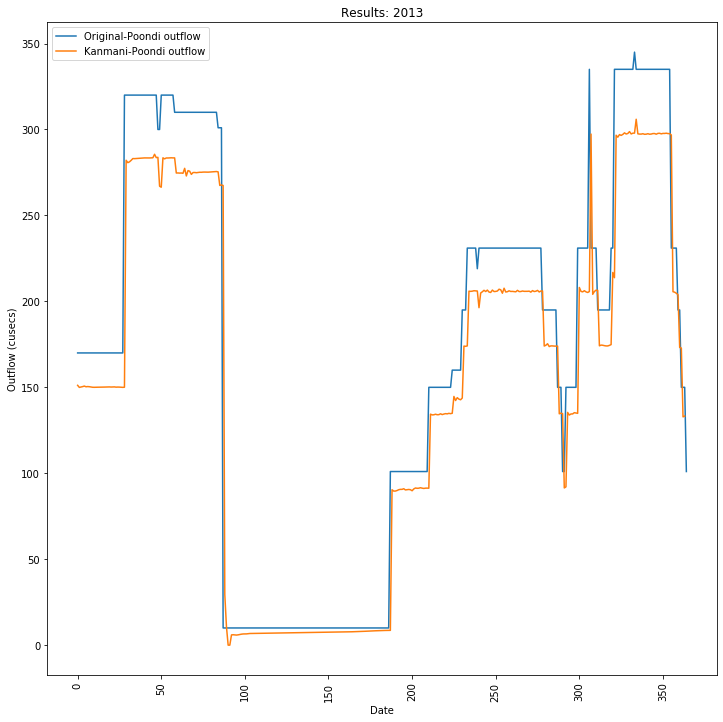

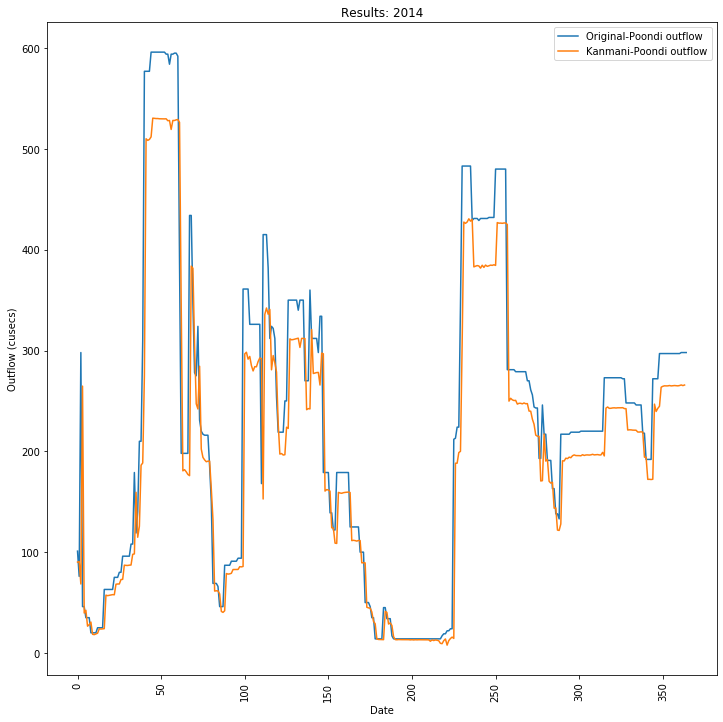

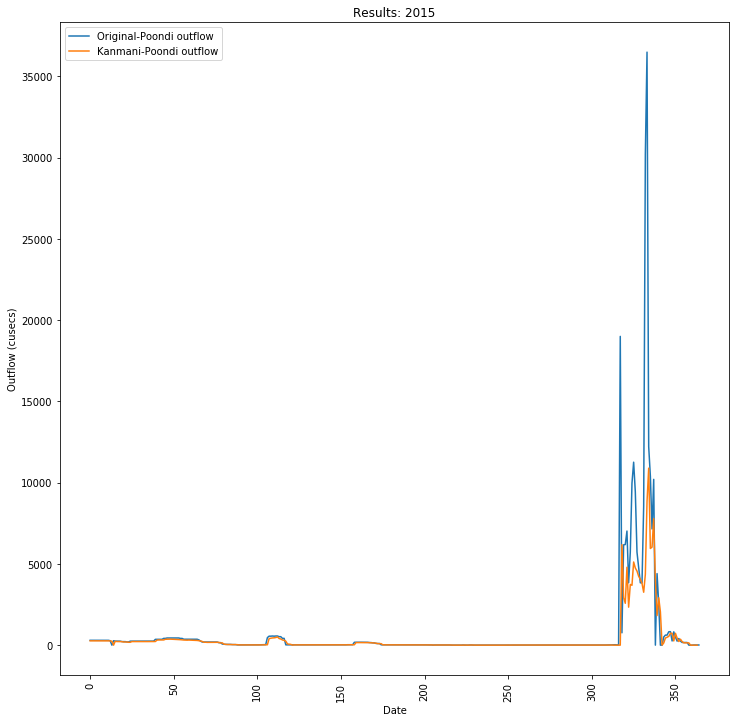

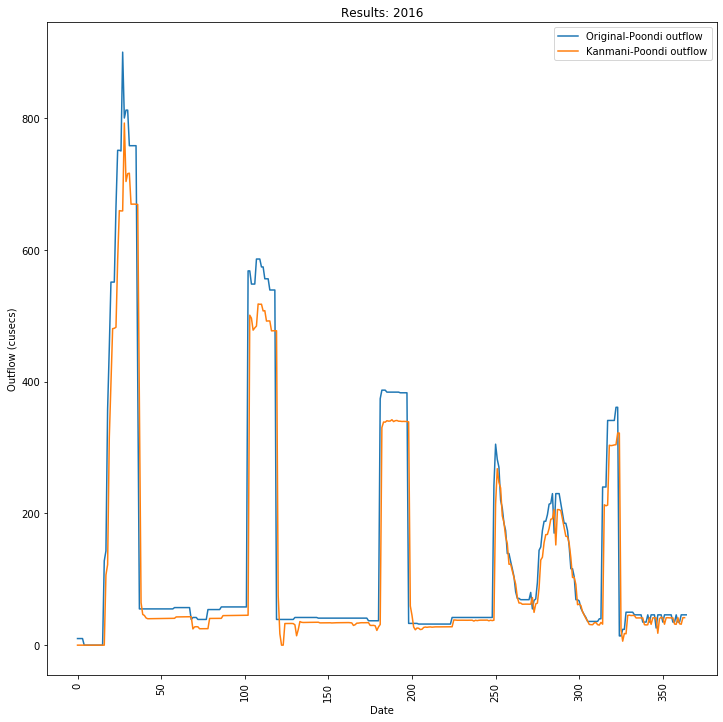

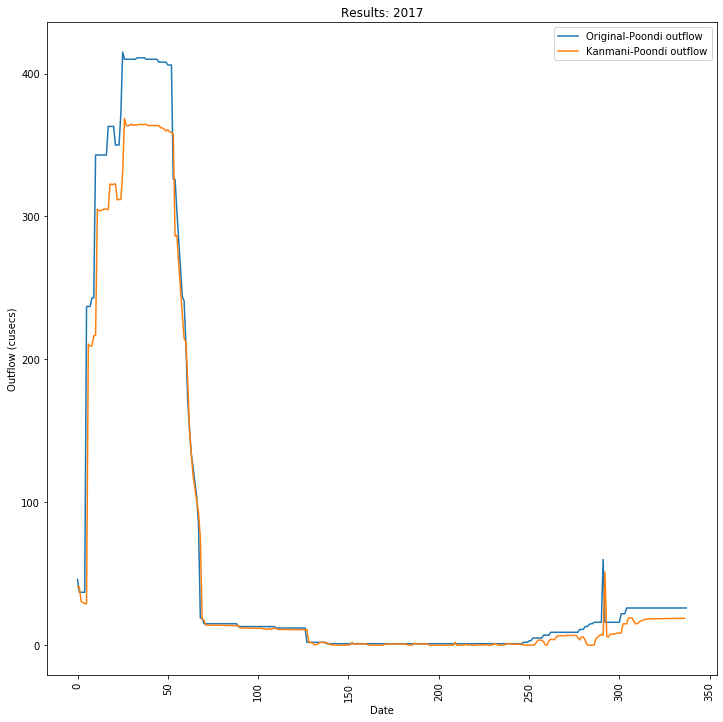

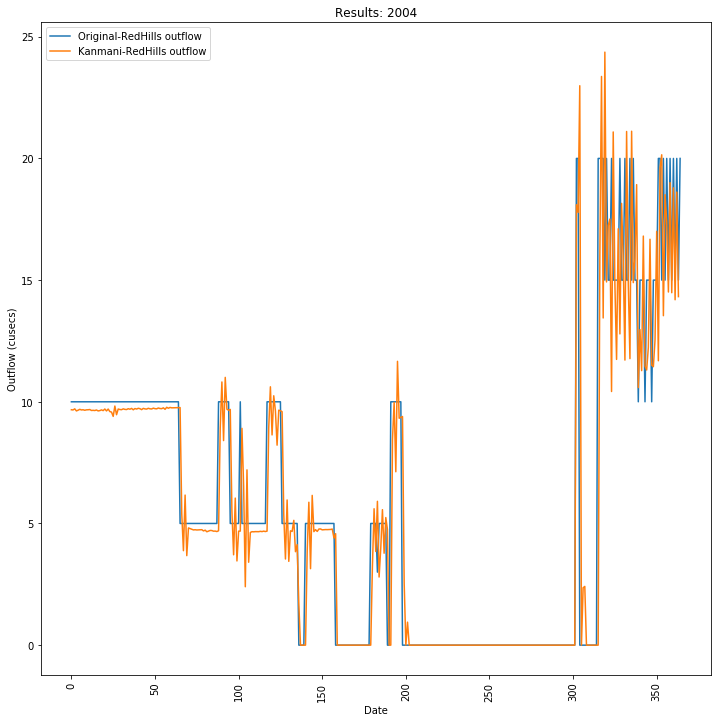

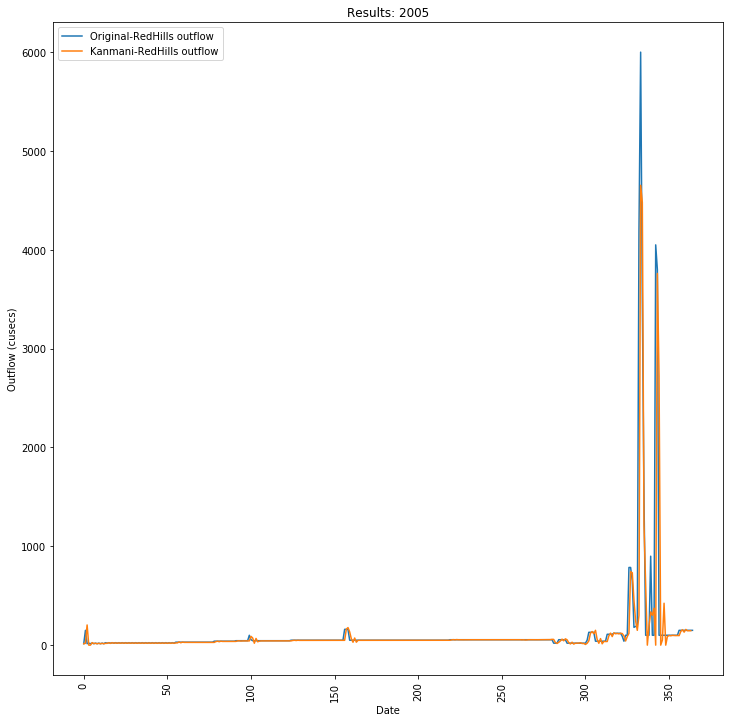

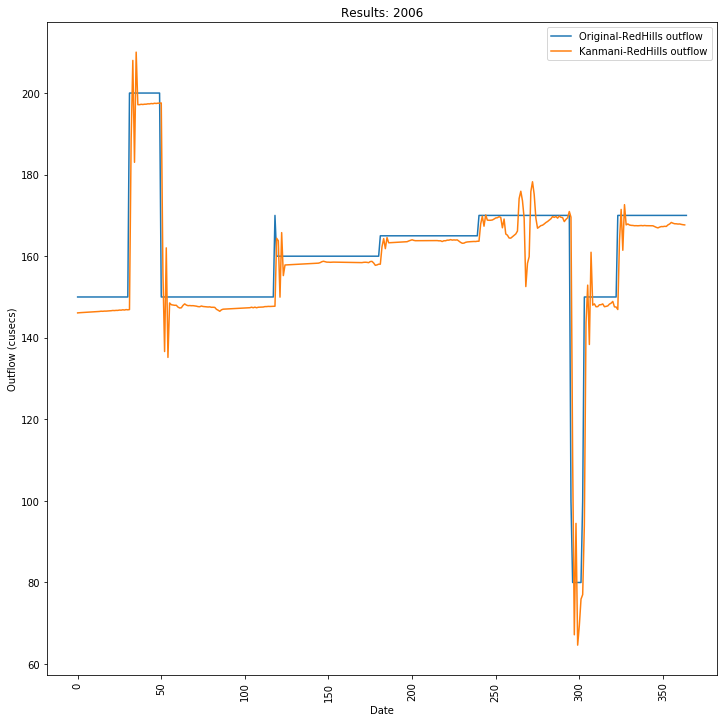

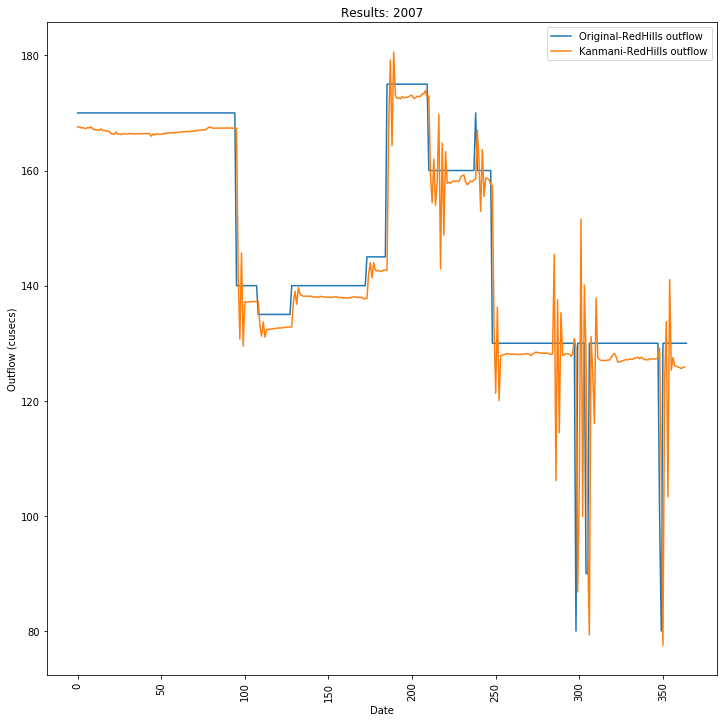

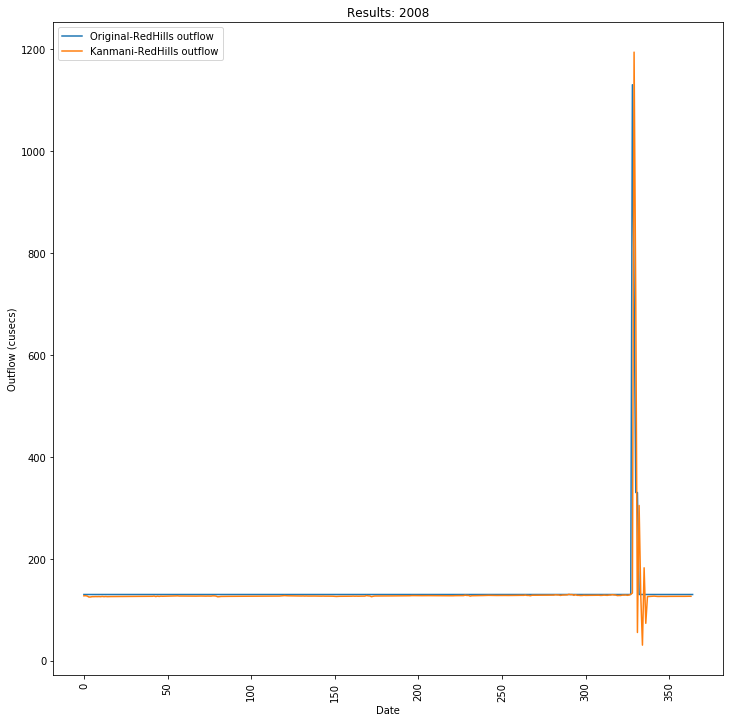

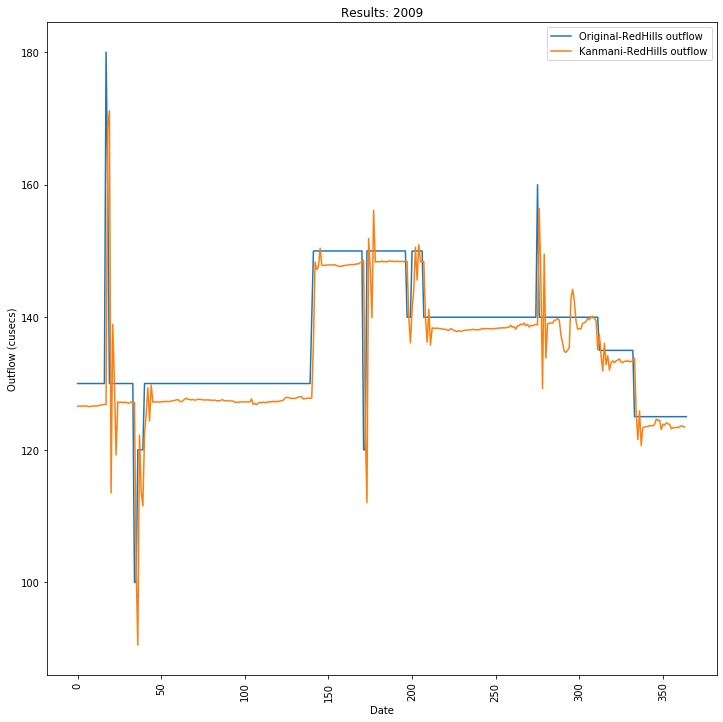

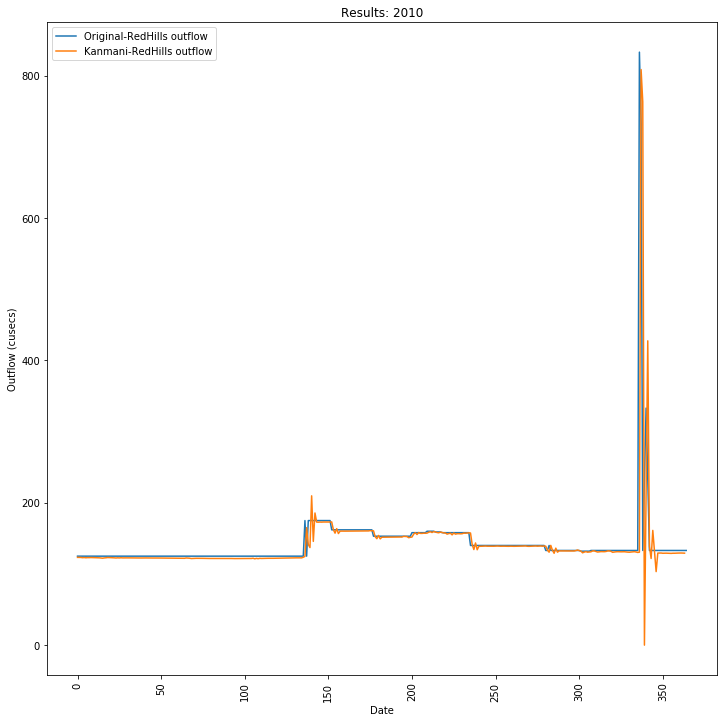

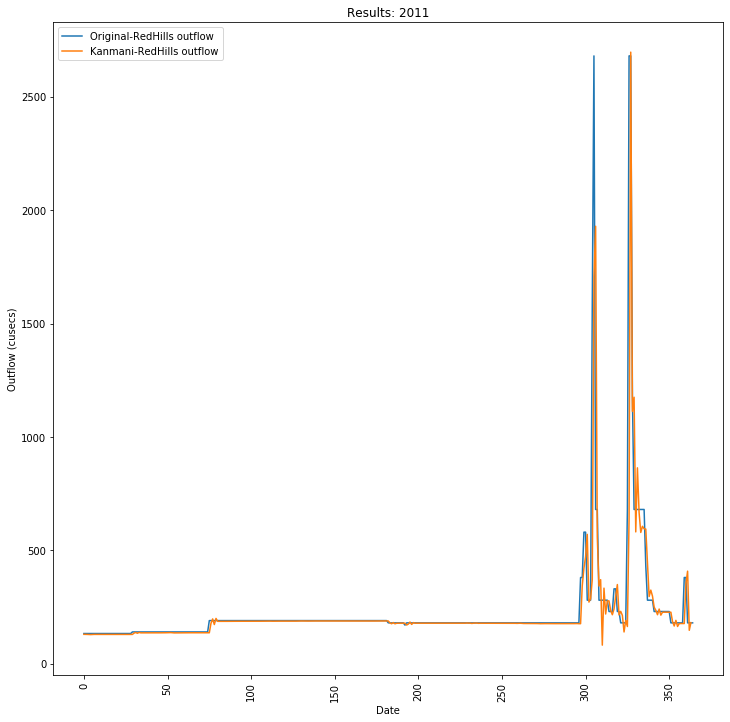

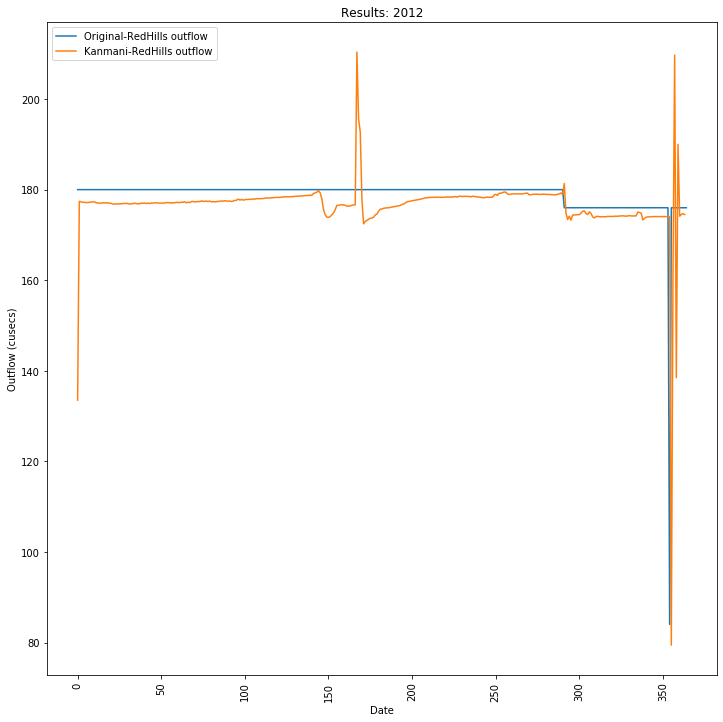

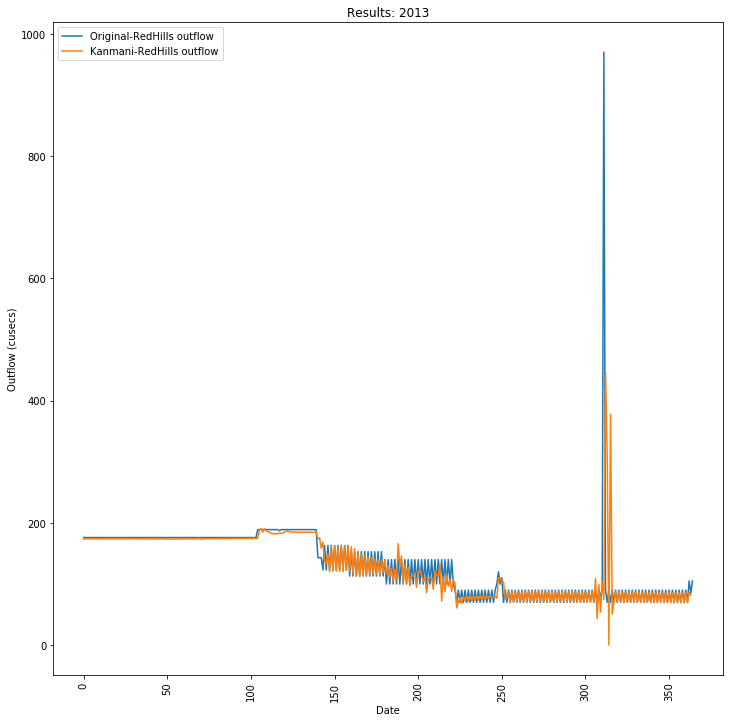

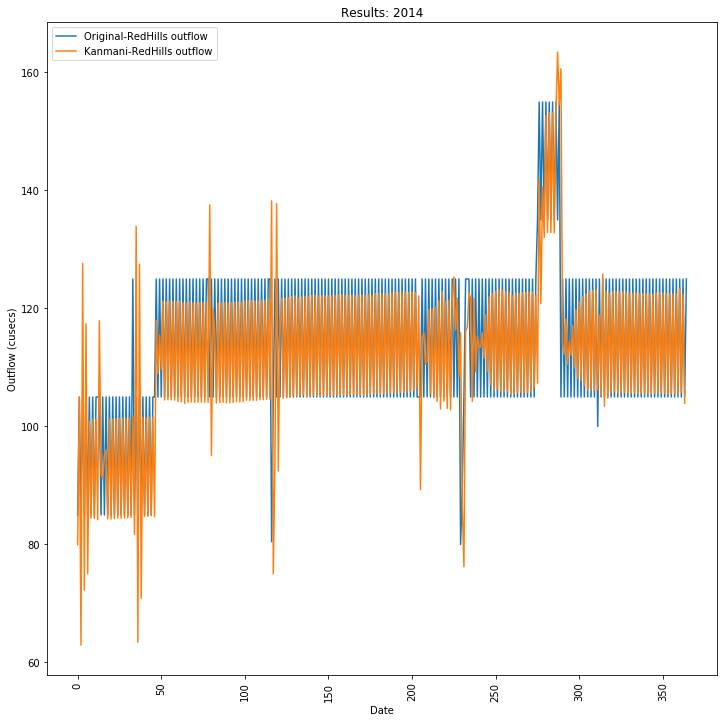

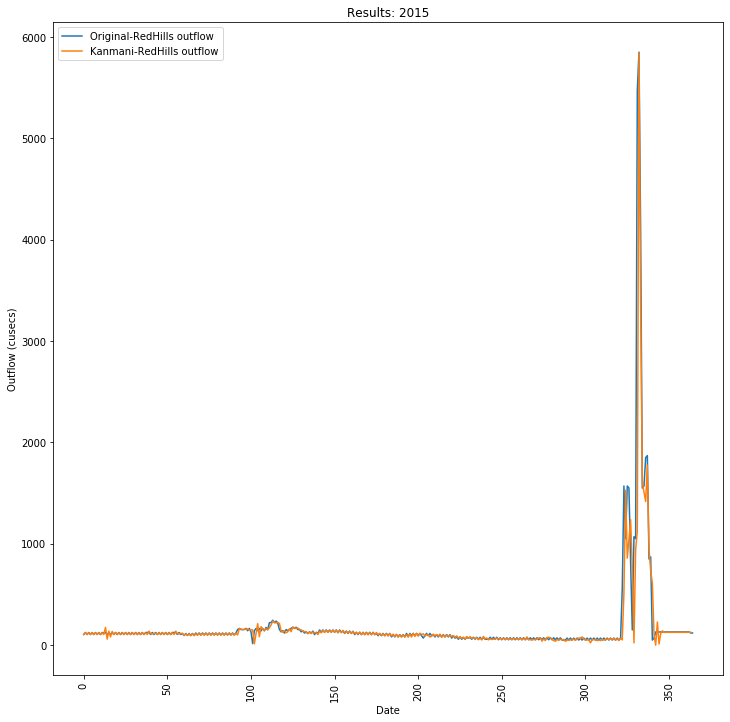

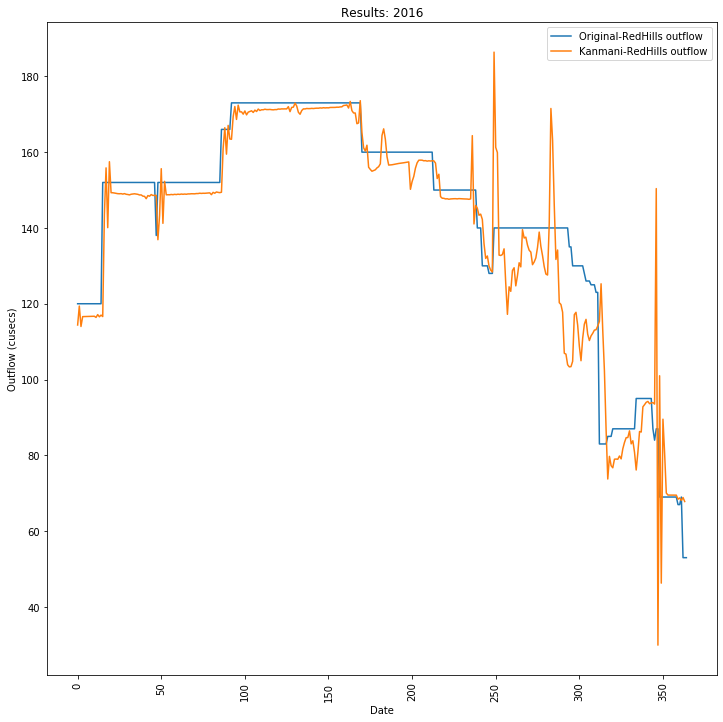

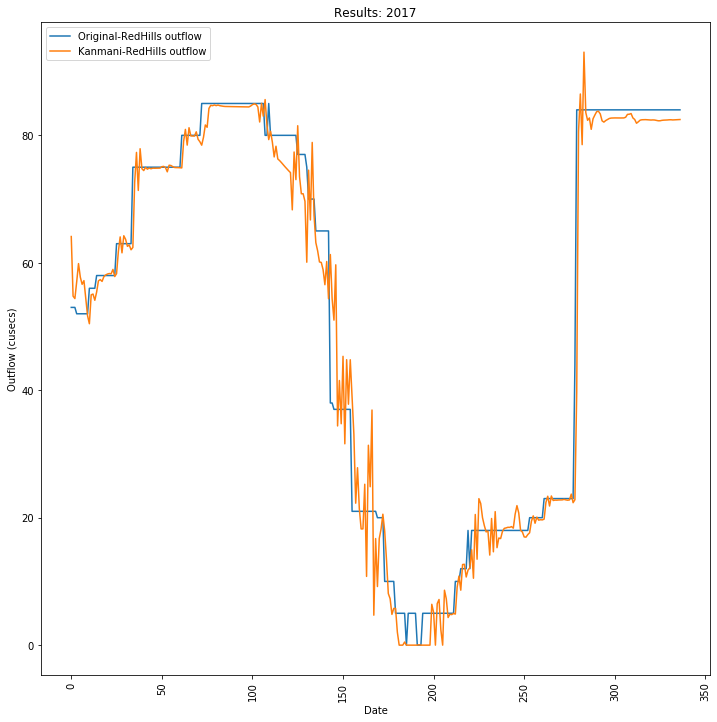

In [31]:
import matplotlib.pyplot as plt
for ij in range(0,4):
    for i in range(0,14):
                                                                  start=365*i
                                                                  end=start+365
                                                                  lookback=5
                                                                  s1=start+1
                                                                  e1=end+1
                                                                  plt.figure(figsize=(12,12))
                                                                  plt.plot(dianna[ij].loc[start+lookback:end+lookback-1,['Outflow (cusecs)']].values,label=('Original-'+revdict[ij] +' outflow'))
                                                                  plt.plot(a[ij][start+lookback:end+lookback-1],label=('Kanmani-'+revdict[ij] +' outflow'))
                                                                  plt.xticks(rotation=90)
                                                                  plt.legend()
                                                                  ste='Results: '+str(2004+i)
                                                                  plt.title(ste)
                                                                  plt.ylabel('Outflow (cusecs)')
                                                                  plt.xlabel('Date')
                                                                  #plt.legend('Original-Chembarambaakam outflow','LSTM-Chembarambaakam outflow')
                                                                  #plt.savefig('D:\\Semester 4\\Soft Computing\\Chennai Water Supply Manager\\v0.jpeg')
                                                                  plt.show()

In [67]:
modelv3=models.load_model('kanmanip1.h5')
modelv2=models.Model(inputs=[model.inputs[0],model.inputs[1],modelv3.inputs[0],model.inputs[3]],outputs=[model.outputs[0],model.outputs[1],modelv3.outputs[0],model.outputs[3]])

ValueError: The name "flatten_9" is used 2 times in the model. All layer names should be unique.

In [69]:

# Writing to an excel  
# sheet using Python 
import xlwt 
from xlwt import Workbook 
  
# Workbook is created 
wb = Workbook() 
  
# add_sheet is used to create sheet. 
sheet1 = wb.add_sheet('Main_sheet') 
  
sheet1.write(0, 0, 'Date')
sheet1.write(0, 1, 'nth day in year')

sheet1.write(0, 2, 'Storage (mcft)') 
sheet1.write(0, 3, 'Inflow (cusecs)') 
sheet1.write(0, 4, 'Rainfall (mm)') 
sheet1.write(0, 5, 'Outflow (cusecs)')
sheet1.write(0,6, 'Reservoir')

required_td=[14,15,17,16,23,24,26,25,32,33,35,34,50,51,53,52]
content=''

import requests
#with open('C:\Users\R. Senthil Kumar\AppData\Local\Programs\Python\Python38-32\content.txt', 'r') as content_file:
  #  content = content_file.read()
from datetime import datetime  
from datetime import timedelta  
def findoccurence(n):
    global content
    position=0
    for i in range(0,n):
        temp=content[content.find('<td ',position):content.find('</td>',position)]
        #print(temp)
        temp=temp[temp.rfind('>',0,temp.find('</font>')-1)+1:temp.find('</font>')]
        #(temp)
        
        position=content.find('</td>',position)+1
    try:
        float(temp)
        return temp
    except:
        return -1

matrix=[]
sdate='01/05/2020'#input('Enter starting date in dd-mm-yyyy format: ')
edate='29/05/2020'#input('Enter ending date in dd-mm-yyyy format: ')
x=datetime.strptime(sdate,'%d/%m/%Y')
y=datetime.strptime(edate,'%d/%m/%Y')
y+=timedelta(days=1)
edate=y.strftime("%d")+'/'+y.strftime("%m")+'/'+y.strftime("%Y")
stringer=x.strftime("%d")+'/'+x.strftime("%m")+'/'+x.strftime("%Y")

controller=1
print('Deploying SPYder, please wait...\n(do not disconnect the net-connection or abort the process)\n')
while(stringer!=edate):
    print('current SPYder rezendevous: '+stringer)
    matrix.append(list())
    diff=(x-datetime(int(x.strftime("%Y")),1,1)).days
    sheet1.write(controller,0,stringer)
    #print(matrix,matrix[0],controller)
    #matrix[controller-1].append(stringer)
    sheet1.write(controller,1,diff)
    pointer=2
    parameters = {'ldate':stringer}
    r = requests.post('http://123.63.203.150/reserve.asp', data=parameters)
    content=r.text
    origin=1
    for i in required_td:
        #print(controller,pointer,float(findoccurence(i)))
        sheet1.write(controller,pointer,float(findoccurence(i)))
        matrix[controller-1].append(float(findoccurence(i)))
        pointer+=1
        if((pointer-1)%5==0):
            sheet1.write(controller,pointer,origin)
            #matrix[controller-1].append(origin)
            origin+=1
            if(origin==5):
                break
            else:
                controller+=1
                sheet1.write(controller,0,stringer)
                matrix.append(list())
                #matrix[controller-1].append(stringer)
                sheet1.write(controller,1,diff)
                pointer=2
        
    x+=timedelta(days=1)
    stringer=x.strftime("%d")+'/'+x.strftime("%m")+'/'+x.strftime("%Y")
    controller+=1
'''
wb.save('reservoir_test.csv')
print('SPYder deploy success, please open reservoir.xls sheet in your local folder\n')

files.download('reversoir.xls')
'''

mdayss=29
#print(matrix)
for mdays in range(0,mdayss):
    temp=matrix[mdays*4]
    matrix[mdays*4]=matrix[mdays*4+3]
    matrix[mdays*4+3]=matrix[mdays*4+2]
    matrix[mdays*4+2]=temp
#print(matrix)

for day in range(0,mdayss-6+1):
    starter=4*day
    r=modelv2.predict([
                    np.array([[matrix[starter],matrix[4+starter],matrix[8+starter],matrix[12+starter],matrix[16+starter]]]),
                    np.array([[matrix[starter+1],matrix[4+starter+1],matrix[8+starter+1],matrix[12+starter+1],matrix[16+starter+1]]]),
                    np.array([[matrix[starter+2],matrix[4+starter+2],matrix[8+starter+2],matrix[12+starter+2],matrix[16+starter+2]]]),
                    np.array([[matrix[starter+3],matrix[4+starter+3],matrix[8+starter+3],matrix[12+starter+3],matrix[16+starter+3]]]),
                    ])
    '''
    r2=modelv3.predict(np.array([[matrix[starter+2],matrix[4+starter+2],matrix[8+starter+2],matrix[12+starter+2],matrix[16+starter+2]]]))
    #print('\n',day,' Predicted: \n')
    print(r2[0][0])
    print('\n',day,' :\n')
    
    for i in range(0,4):
        
        print(matrix[20+starter+i][3],end=',')
    
    '''
    print('\nvv',day,':')
    
    for i in range(0,4):
        
            print((r[i][0][0]/matrix[20+starter+i][3]-1)*100,end=',')


Deploying SPYder, please wait...
(do not disconnect the net-connection or abort the process)

current SPYder rezendevous: 01/05/2020
current SPYder rezendevous: 02/05/2020
current SPYder rezendevous: 03/05/2020
current SPYder rezendevous: 04/05/2020
current SPYder rezendevous: 05/05/2020
current SPYder rezendevous: 06/05/2020
current SPYder rezendevous: 07/05/2020
current SPYder rezendevous: 08/05/2020
current SPYder rezendevous: 09/05/2020
current SPYder rezendevous: 10/05/2020
current SPYder rezendevous: 11/05/2020
current SPYder rezendevous: 12/05/2020
current SPYder rezendevous: 13/05/2020
current SPYder rezendevous: 14/05/2020
current SPYder rezendevous: 15/05/2020
current SPYder rezendevous: 16/05/2020
current SPYder rezendevous: 17/05/2020
current SPYder rezendevous: 18/05/2020
current SPYder rezendevous: 19/05/2020
current SPYder rezendevous: 20/05/2020
current SPYder rezendevous: 21/05/2020
current SPYder rezendevous: 22/05/2020
current SPYder rezendevous: 23/05/2020
current S

C:\Users\R. Senthil Kumar\anaconda3\lib\site-packages\ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide


In [12]:
from keras.utils import plot_model
plot_model(mode)

TypeError: 'InputLayer' object is not iterable

In [6]:
sequence

[array([[[   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.]],
 
        [[   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.]],
 
        [[   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.]],
 
        ...,
 
        [[1879.,    0.,    2.,   49.],
         [1875.,    0.,    0.,   48.],
         [1871.,    0.,    0.,   54.],
         [1867.,    0.,    0.,   49.],
         [1863.,    0.,    0.,   49.]],
 
        [[1875.,    0.,    0.,   48.],
         [1871.,    0.,    0.,   54.],
         [1867.,    0.,    0.,   49.],
         [1863.,    0.,    0.,   49.],
         [1859.,    0.,    0.,   49.]

In [14]:
from tensorflow.keras import models
m=models.load_model('kanmani29.h5')

In [15]:
m.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input0 (InputLayer)             [(None, 5, 4)]       0                                            
__________________________________________________________________________________________________
Input1 (InputLayer)             [(None, 5, 4)]       0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 5, 4)]       0                                            
__________________________________________________________________________________________________
Input3 (InputLayer)             [(None, 5, 4)]       0                                            
____________________________________________________________________________________________

In [13]:
target

[array([ 0.,  0.,  0., ..., 49., 49., 49.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 0.,  0.,  0., ..., 26., 26., 26.]),
 array([10., 10., 10., ..., 84., 84., 84.])]

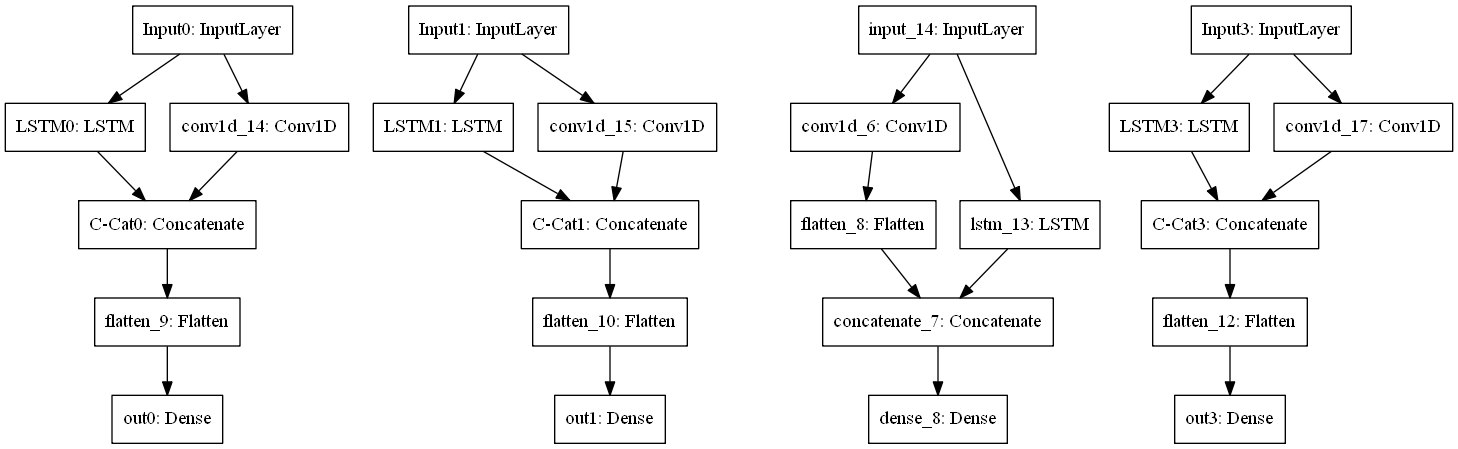

In [17]:
tf.keras.utils.plot_model(
    m, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False
)